In [ ]:
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from tqdm import tqdm
import random
import os
import time
import h5py
from datetime import datetime


import keras
from keras import losses, layers, optimizers, regularizers
import tensorflow as tf
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Conv2DTranspose

from sklearn.cluster import KMeans

import auxlib; importlib.reload(auxlib)

Importing library...
Library successfully imported
Importing library...
Library successfully imported


<module 'auxlib' from 'd:\\Facultad\\Doctorado\\Proyectos\\Uncovering Magnetic Phases\\auxlib\\__init__.py'>

# Variables

In [2]:
L = 40

training = ['ferro', 'neel', 'stripe']

densities = [0.55, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.7, 0.8, 0.9, 1.0]

densities_str = ['055','06', '061', '062', '063', '064', '065', '07', '08', '09','1']

temperatures = np.linspace(0.0, 5.0, 251)

seed = 20

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Directories

In [3]:
folder = auxlib.folders(type='cae', training=training)
folder_figs = auxlib.folders_figs(type='cae', training=training)

# Synthetic data

In [9]:
# Initialize the synthetic image generator

data = auxlib.SyntheticImagesGen(training=training, L=L)

# Generate synthetic data

train_images, train_labels = data.dataGenerator(12000)
test_images, test_labels = data.dataGenerator(1200)

Generating synthetic data...
Done!
Elapsed time: 1.0198578834533691 seconds
Generating synthetic data...
Done!
Elapsed time: 0.10023212432861328 seconds


In [10]:
train_labels.shape

(12000,)

In [11]:
# Print the number of samples in each class

l, m, n, o = 0, 0, 0, 0

for i in range(len(list(train_labels))):
	if train_labels[i] == 0:
		l += 1
	elif train_labels[i] == 1:
		m += 1
	elif train_labels[i] == 2:
		n += 1
	elif train_labels[i] == 3:
		o += 1
print("Number of paramagnetic samples: ", l)
print("Number of ferromagnetic samples: ", m)
print("Number of neel samples: ", n)
print("Number of stripe samples: ", o)
print("Total number of samples: ", l + m + n + o)

Number of paramagnetic samples:  0
Number of ferromagnetic samples:  3000
Number of neel samples:  3000
Number of stripe samples:  6000
Total number of samples:  12000


# Anomaly detector function

In [12]:
def anomaly_detector(L = 40, conv_dim=[32,16], filter_size = 3, pooling_size = 2, rl2 = 1E-4, lr=2E-3, DO = 0.2):

	input_img = keras.Input(shape=(L, L, 1))


	x = layers.Conv2D(conv_dim[0], kernel_size = 3, activation = 'relu', padding='same',
				strides = pooling_size, kernel_regularizer = regularizers.l2(rl2),
				bias_regularizer = regularizers.l2(rl2))(input_img)
	#
	x = layers.Dropout(DO)(x)
	#
	#
	x = layers.Conv2D(conv_dim[1], kernel_size = 2, activation='relu', padding='same', strides = pooling_size,
				kernel_regularizer=regularizers.l2(rl2), bias_regularizer=regularizers.l2(rl2))(x)
	#
	encoded = layers.Dropout(DO)(x)

	# decoder

	x = layers.Conv2DTranspose(conv_dim[1], kernel_size = 2, strides = pooling_size,
						activation='relu', padding='same', kernel_regularizer = regularizers.l2(rl2),
							bias_regularizer = regularizers.l2(rl2))(encoded)

	x = layers.Dropout(DO)(x)
	#
	x = layers.Conv2DTranspose(conv_dim[0], kernel_size = 3, strides = pooling_size, activation = 'relu',
						padding = 'same', kernel_regularizer = regularizers.l2(rl2),
									bias_regularizer = regularizers.l2(rl2))(x)

	x = layers.Dropout(DO)(x)

	decoded = layers.Conv2D(1, kernel_size = (filter_size, filter_size),padding = 'same',  activation='sigmoid')(x)

	autoencoder = keras.Model(input_img, decoded)

	encoder = keras.Model(input_img, encoded)

	print(autoencoder.summary())

	autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

	return autoencoder,encoder

# Setting the CAE

In [13]:
neurons = 8

autoencoder, encoder = anomaly_detector(L = 40, conv_dim=[8, neurons],
									filter_size = 3, pooling_size = 2, rl2 = 1E-3, lr=2E-3, DO = 0.25)

autoencoder.fit(train_images, train_images,
			epochs=150,
			batch_size=64,
			shuffle=True,
			validation_data=(train_images, train_images) )

autoencoder.save(os.path.join(folder, f'auto_{neurons}.h5'))
encoder.save(os.path.join(folder, f'enco_{neurons}.h5'))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40, 40, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 8)         80        
                                                                 
 dropout_4 (Dropout)         (None, 20, 20, 8)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 8)         264       
                                                                 
 dropout_5 (Dropout)         (None, 10, 10, 8)         0         
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 20, 20, 8)         264       
 Transpose)                                                      
                                                           

c:\ProgramData\Anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Montecarlo data

In [14]:
loader_init = auxlib.loader_and_saver(os.getcwd())

# Predictions

Calcula las predicciones y guarda todas las reconstrucciones en una lista, "pred_cae". Esta lista será guardada.

In [15]:
pred_cae = []

neurons = 8

for density_index, density in enumerate(densities):
	sim_images, temperature = loader_init.simulatedImages(density_index)

	model_path_cae = os.path.join(folder, f'auto_{neurons}.h5')

	cae = keras.models.load_model(model_path_cae)

	predict_cae = []

	for temp in tqdm(range(len(temperature)),
                            desc="Predicting", unit="Temperature units"):

		prediction_cae = cae.predict(np.array(sim_images)[:,temp,:,:], verbose=False)

		predict_cae.append(prediction_cae)

	pred_cae.append(np.array(predict_cae))

Loading simulated images...


Loading arrays: 100%|██████████| 196/196 [00:03<00:00, 59.34array/s]


Files loaded!
Data of density p = 0.55 succesfully loaded.


Predicting: 100%|██████████| 251/251 [03:35<00:00,  1.16Temperature units/s]


Loading simulated images...


Loading arrays: 100%|██████████| 150/150 [00:03<00:00, 37.99array/s]


Files loaded!
Data of density p = 0.6 succesfully loaded.


Predicting: 100%|██████████| 251/251 [02:15<00:00,  1.86Temperature units/s]


Loading simulated images...


Loading arrays: 100%|██████████| 199/199 [00:03<00:00, 52.37array/s]


Files loaded!
Data of density p = 0.61 succesfully loaded.


Predicting: 100%|██████████| 251/251 [03:01<00:00,  1.38Temperature units/s]


Loading simulated images...


Loading arrays: 100%|██████████| 187/187 [00:04<00:00, 45.22array/s]


Files loaded!
Data of density p = 0.62 succesfully loaded.


Predicting: 100%|██████████| 251/251 [02:42<00:00,  1.54Temperature units/s]


Loading simulated images...


Loading arrays: 100%|██████████| 163/163 [00:02<00:00, 80.84array/s]


Files loaded!
Data of density p = 0.63 succesfully loaded.


Predicting: 100%|██████████| 251/251 [01:44<00:00,  2.40Temperature units/s]


Loading simulated images...


Loading arrays: 100%|██████████| 142/142 [00:01<00:00, 83.03array/s] 


Files loaded!
Data of density p = 0.64 succesfully loaded.


Predicting: 100%|██████████| 251/251 [01:36<00:00,  2.60Temperature units/s]


Loading simulated images...


Loading arrays: 100%|██████████| 161/161 [00:02<00:00, 67.85array/s]


Files loaded!
Data of density p = 0.65 succesfully loaded.


Predicting: 100%|██████████| 251/251 [01:52<00:00,  2.23Temperature units/s]


Loading simulated images...


Loading arrays: 100%|██████████| 151/151 [00:02<00:00, 73.98array/s]


Files loaded!
Data of density p = 0.7 succesfully loaded.


Predicting: 100%|██████████| 251/251 [01:35<00:00,  2.63Temperature units/s]


Loading simulated images...


Loading arrays: 100%|██████████| 155/155 [00:02<00:00, 60.05array/s]


Files loaded!
Data of density p = 0.8 succesfully loaded.


Predicting: 100%|██████████| 251/251 [01:50<00:00,  2.27Temperature units/s]


Loading simulated images...


Loading arrays: 100%|██████████| 139/139 [00:01<00:00, 75.73array/s]


Files loaded!
Data of density p = 0.9 succesfully loaded.


Predicting: 100%|██████████| 251/251 [01:33<00:00,  2.68Temperature units/s]


Loading simulated images...


Loading arrays: 100%|██████████| 156/156 [00:02<00:00, 67.87array/s]


Files loaded!
Data of density p = 1. succesfully loaded.


Predicting: 100%|██████████| 251/251 [01:44<00:00,  2.41Temperature units/s]


Predictions of the syntethic lattices


In [16]:
# Saving predicted data

with h5py.File(os.path.join(folder, "predicciones_cae.h5"), "w") as f:
	for i in tqdm(range(11), desc="Saving", unit="Density"):
		f.create_dataset(f"pred_cae_{i}", data=np.array(pred_cae[i]))

Saving: 100%|██████████| 11/11 [01:22<00:00,  7.46s/Density]


In [17]:
# Loading predicted data

pred_cae = []
with h5py.File(os.path.join(folder, "predicciones_cae.h5"), "r") as f:
	for i in tqdm(range(11), desc="Loading", unit="Density"):
		pred_cae_ind = np.array(f[f"pred_cae_{i}"])
		pred_cae.append(pred_cae_ind)

Loading: 100%|██████████| 11/11 [00:45<00:00,  4.14s/Density]


Se muestra las dimensiones de cada elemento de la lista "pred_cae". Cada elemento contiene un array con todas las reconstrucciones para todas las temperaturas y todas las repeticiones. Por eso cada elemento tiene dimensiones "(nro_temperaturas, nro_repeticiones, 40, 40, 1)"

In [18]:
for i in range(11):
	print(f'Densidad = {densities[i]:.2f}: ', pred_cae[i].shape)

Densidad = 0.55:  (251, 196, 40, 40, 1)
Densidad = 0.60:  (251, 150, 40, 40, 1)
Densidad = 0.61:  (251, 199, 40, 40, 1)
Densidad = 0.62:  (251, 187, 40, 40, 1)
Densidad = 0.63:  (251, 163, 40, 40, 1)
Densidad = 0.64:  (251, 142, 40, 40, 1)
Densidad = 0.65:  (251, 161, 40, 40, 1)
Densidad = 0.70:  (251, 151, 40, 40, 1)
Densidad = 0.80:  (251, 155, 40, 40, 1)
Densidad = 0.90:  (251, 139, 40, 40, 1)
Densidad = 1.00:  (251, 156, 40, 40, 1)


# Reconstructions

## Synthetic features

In [20]:
neurons = 8

model_path_cae = os.path.join(folder, f'auto_{neurons}.h5')

cae = keras.models.load_model(model_path_cae)

predict_synt = cae.predict(np.array(train_images), verbose=False)

predict_synt = np.array(predict_synt)

In [21]:
predict_synt.shape

(12000, 40, 40, 1)

In [22]:
train_images.shape

(12000, 40, 40)

In [23]:
for i in range(len(train_images)):
  if np.all(train_images[i, 0, :4]==np.ones(4)):
    if np.all(train_images[i, 1, :4]==-np.ones(4)):
      print(i)
      num = i
      break

0


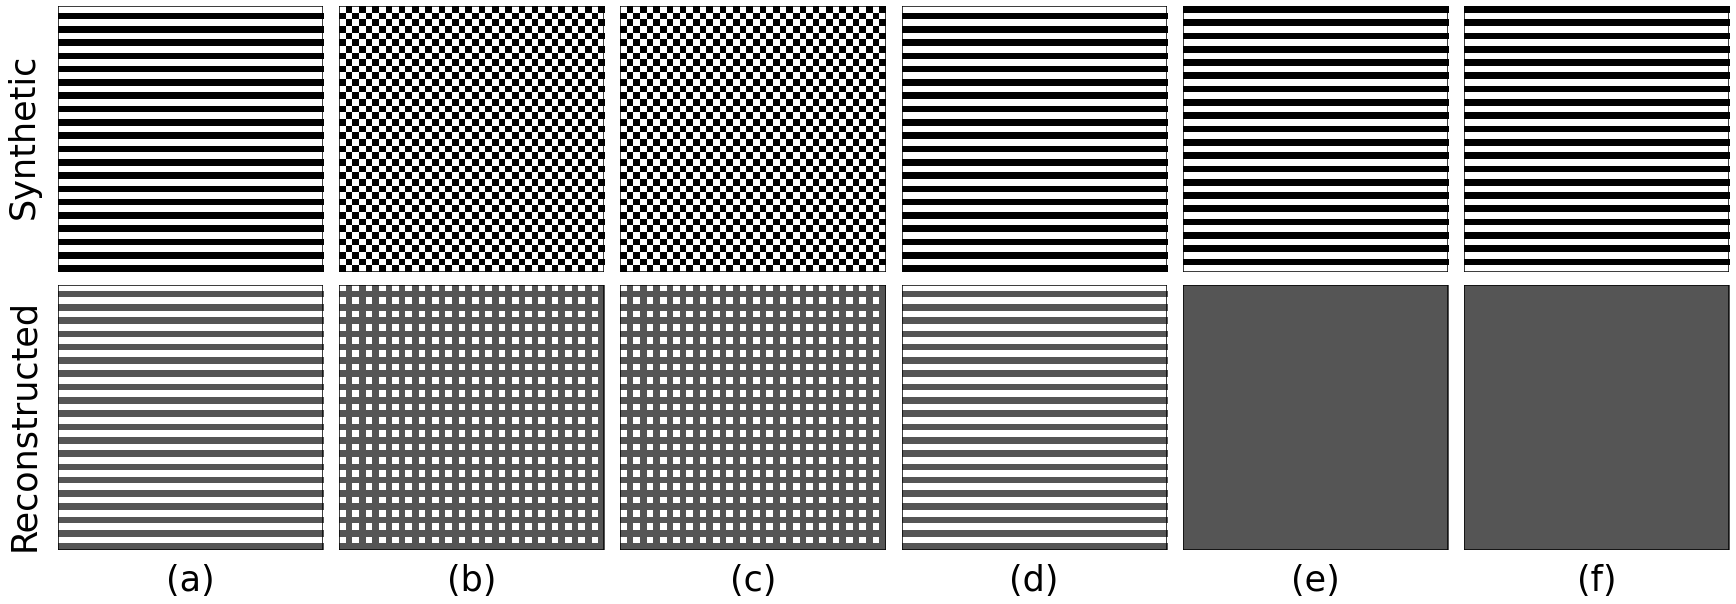

In [25]:
import matplotlib.patches as patches

n = 6

n_list = [5, 27, 3, 0, 1, 6]

items = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

fig, axes = plt.subplots(2, n, figsize=(30, 10), gridspec_kw={'wspace': 0.05, 'hspace': 0.05})

for j in range(6):
    i = n_list[j]
    syn_im = train_images[i, :, :].reshape(L, L)
    pred_im = predict_synt[i, :, :, 0].reshape(L, L)

    # Primera fila (Montecarlo)
    ax = axes[0, j]
    ax.imshow(syn_im, cmap='gray', vmin=-1, vmax=1)
    ax.axis("off")

    # Agregar un borde al gráfico
    rect = patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes,
                            linewidth=1.5, edgecolor='black', facecolor='none')
    ax.add_patch(rect)

    # Segunda fila (Reconstrucción)
    ax = axes[1, j]
    ax.imshow(pred_im, cmap='gray', vmin=-0.5, vmax=1)
    ax.axis("off")

    # Agregar un borde al gráfico
    rect = patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes,
                            linewidth=1.5, edgecolor='black', facecolor='none')
    ax.add_patch(rect)

    axes[1, j].text(0.5, -0.15, f"{items[j]}",
                        fontsize=35, ha="center", transform=ax.transAxes)

# Agregar etiquetas a la izquierda de cada fila
fig.text(0.11, 0.70, "Synthetic", fontsize=35, ha="center", va="center", rotation=90)
fig.text(0.11, 0.30, "Reconstructed", fontsize=35, ha="center", va="center", rotation=90)

plt.savefig(os.path.join(folder_figs, f'synthetic_reconstructions.pdf'), bbox_inches='tight')
plt.show()

## Montecarlo

ESTAN GRAFICADOS EN ESCALA LOGARITMICA CON MUCHOS ORDENES DE MAGNITUD


Loading simulated images...


Loading arrays: 100%|██████████| 196/196 [00:04<00:00, 41.37array/s]


Files loaded!
Data of density p = 0.55 succesfully loaded.


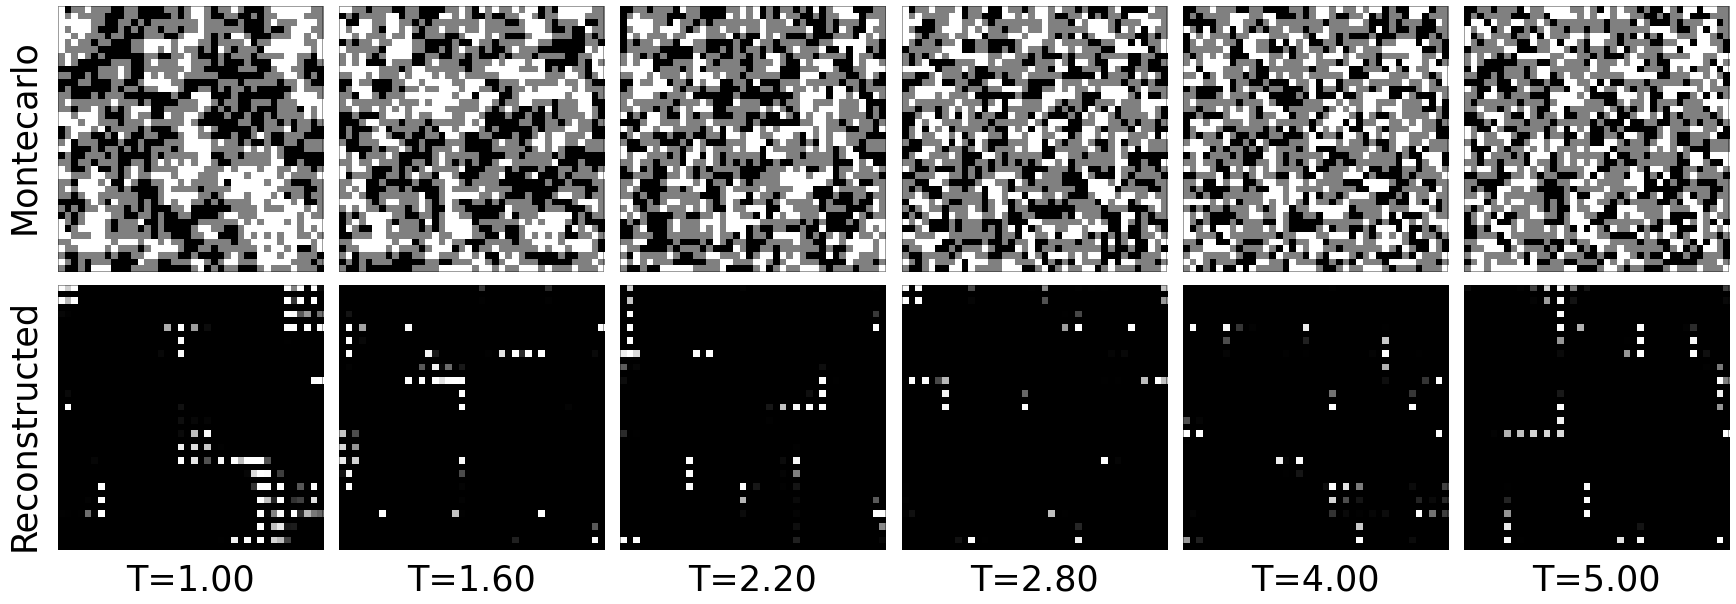

Loading simulated images...


Loading arrays: 100%|██████████| 150/150 [00:05<00:00, 26.55array/s]


Files loaded!
Data of density p = 0.6 succesfully loaded.


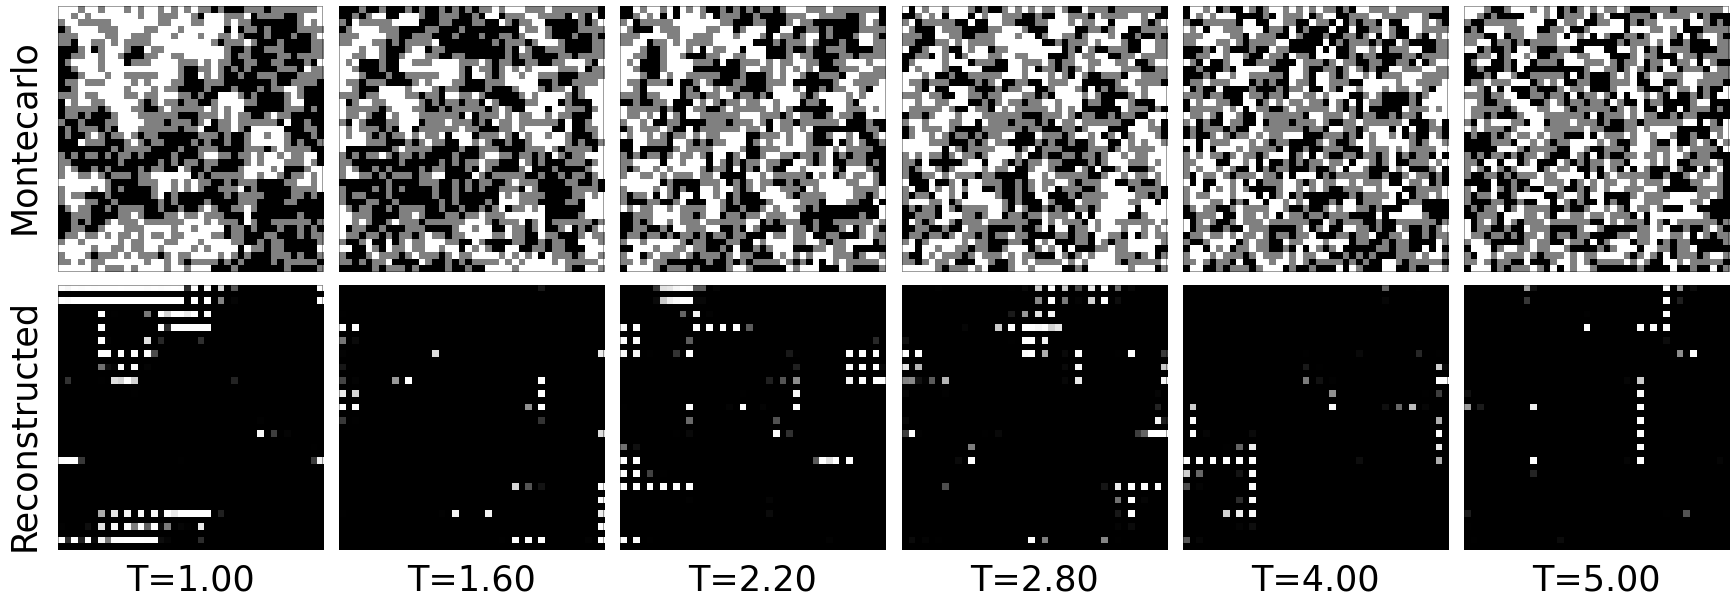

Loading simulated images...


Loading arrays: 100%|██████████| 199/199 [00:03<00:00, 65.01array/s]


Files loaded!
Data of density p = 0.61 succesfully loaded.


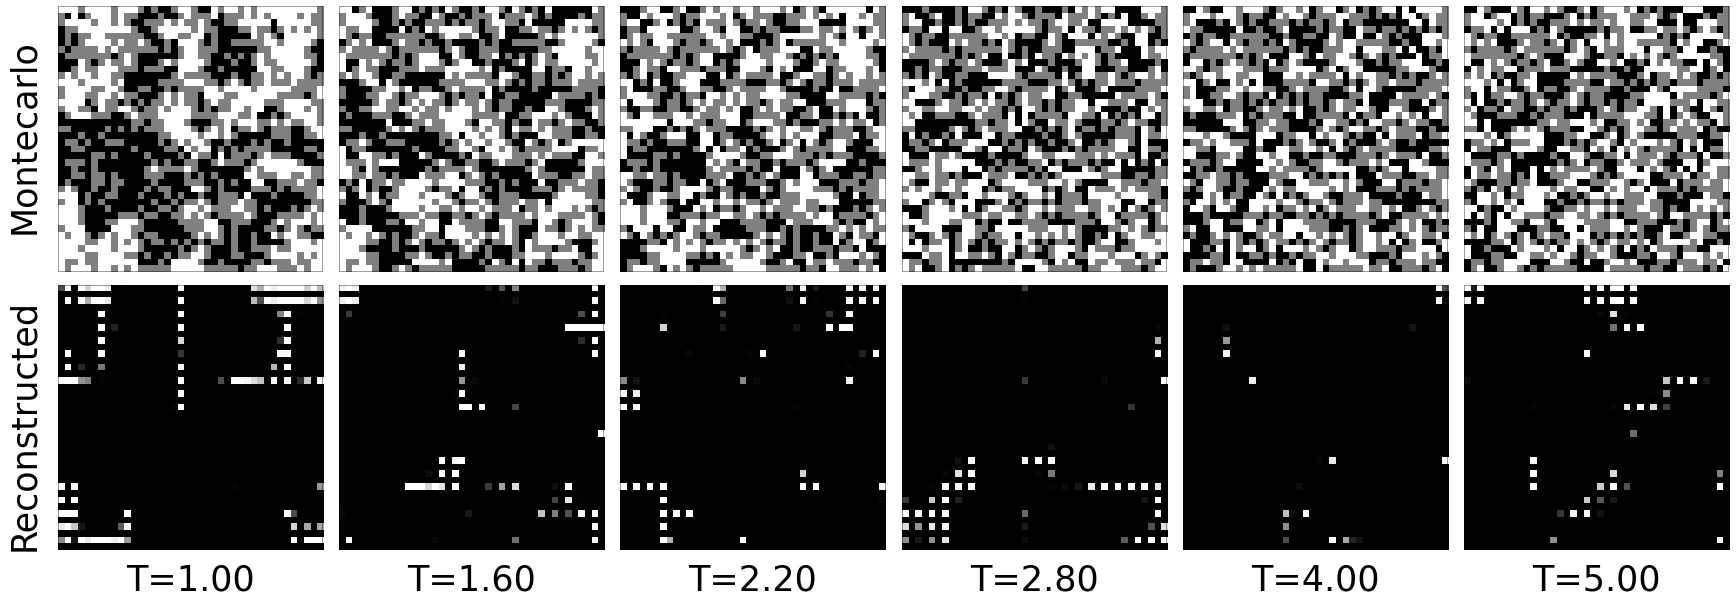

Loading simulated images...


Loading arrays: 100%|██████████| 187/187 [00:04<00:00, 39.14array/s]


Files loaded!
Data of density p = 0.62 succesfully loaded.


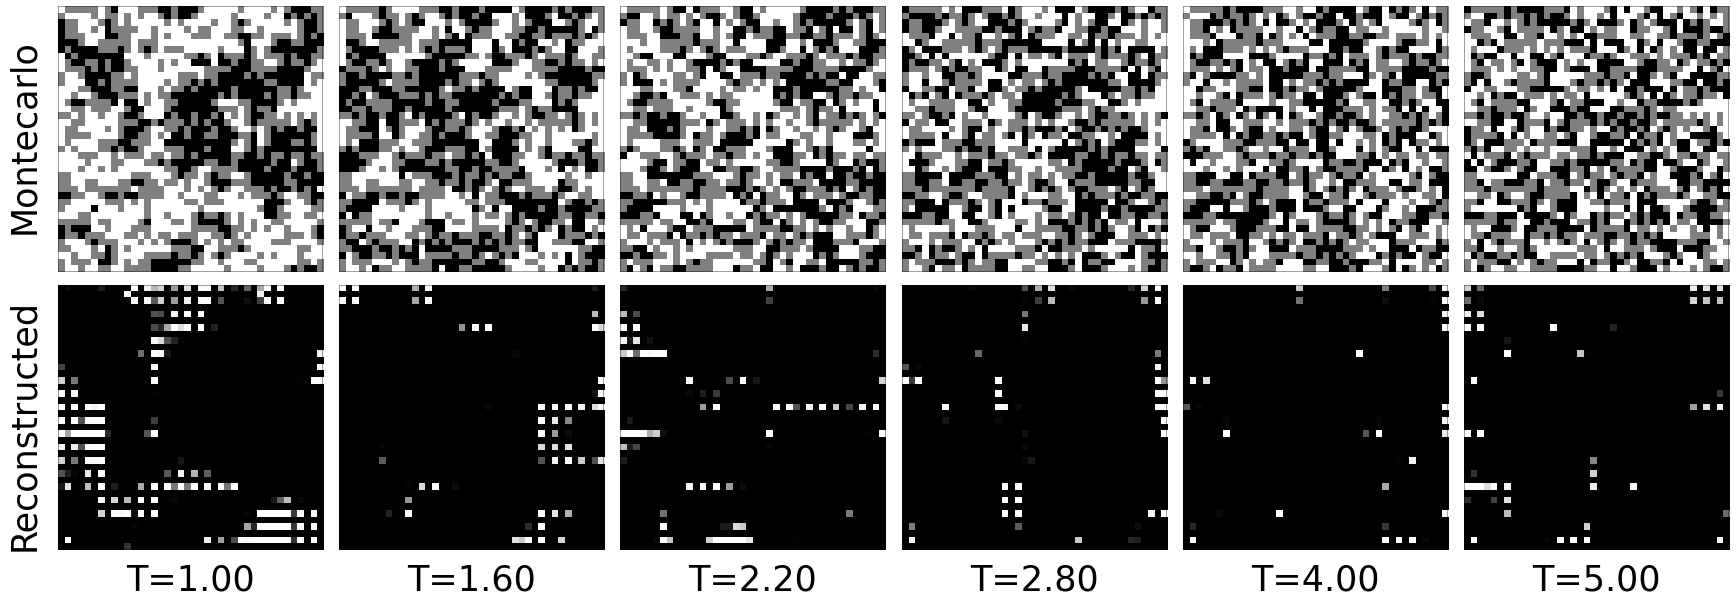

Loading simulated images...


Loading arrays: 100%|██████████| 163/163 [00:03<00:00, 49.12array/s]


Files loaded!
Data of density p = 0.63 succesfully loaded.


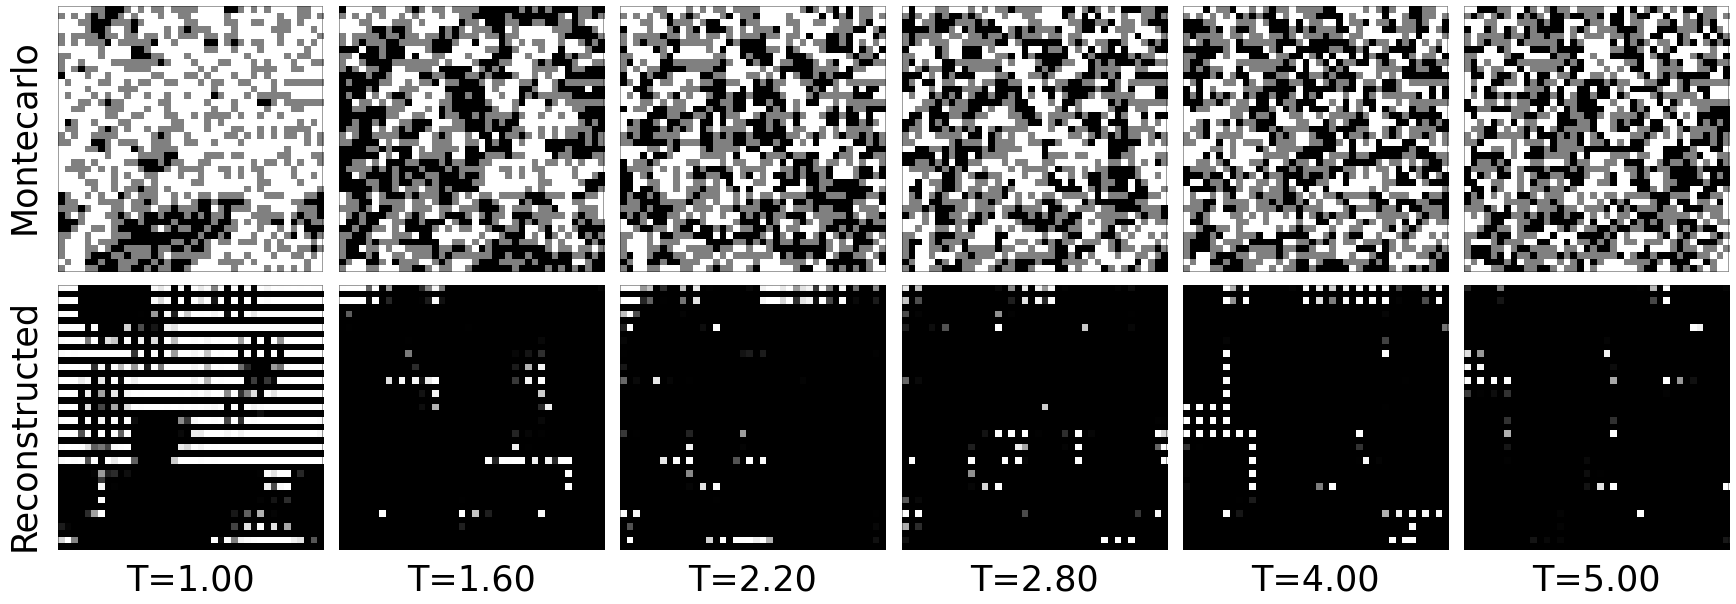

Loading simulated images...


Loading arrays: 100%|██████████| 142/142 [00:03<00:00, 41.87array/s]


Files loaded!
Data of density p = 0.64 succesfully loaded.


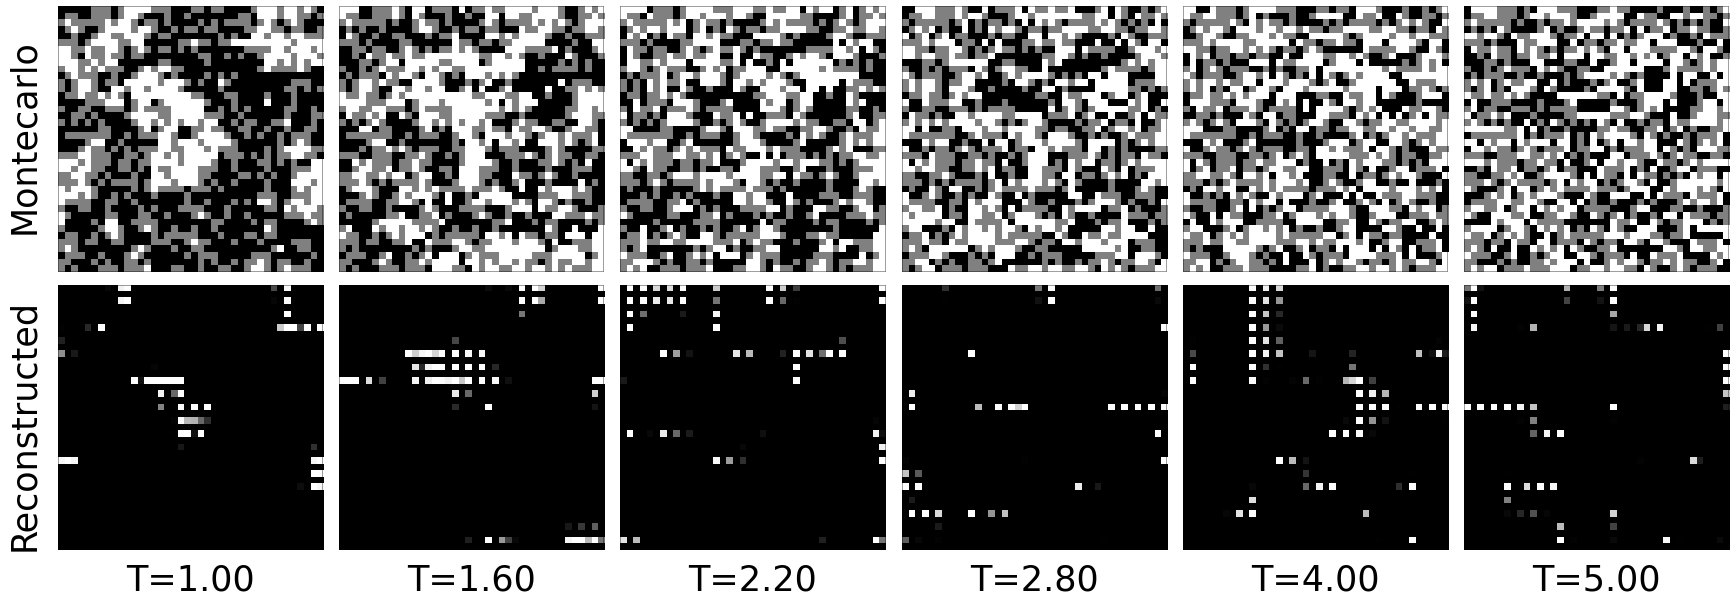

Loading simulated images...


Loading arrays: 100%|██████████| 161/161 [00:02<00:00, 53.72array/s]


Files loaded!
Data of density p = 0.65 succesfully loaded.


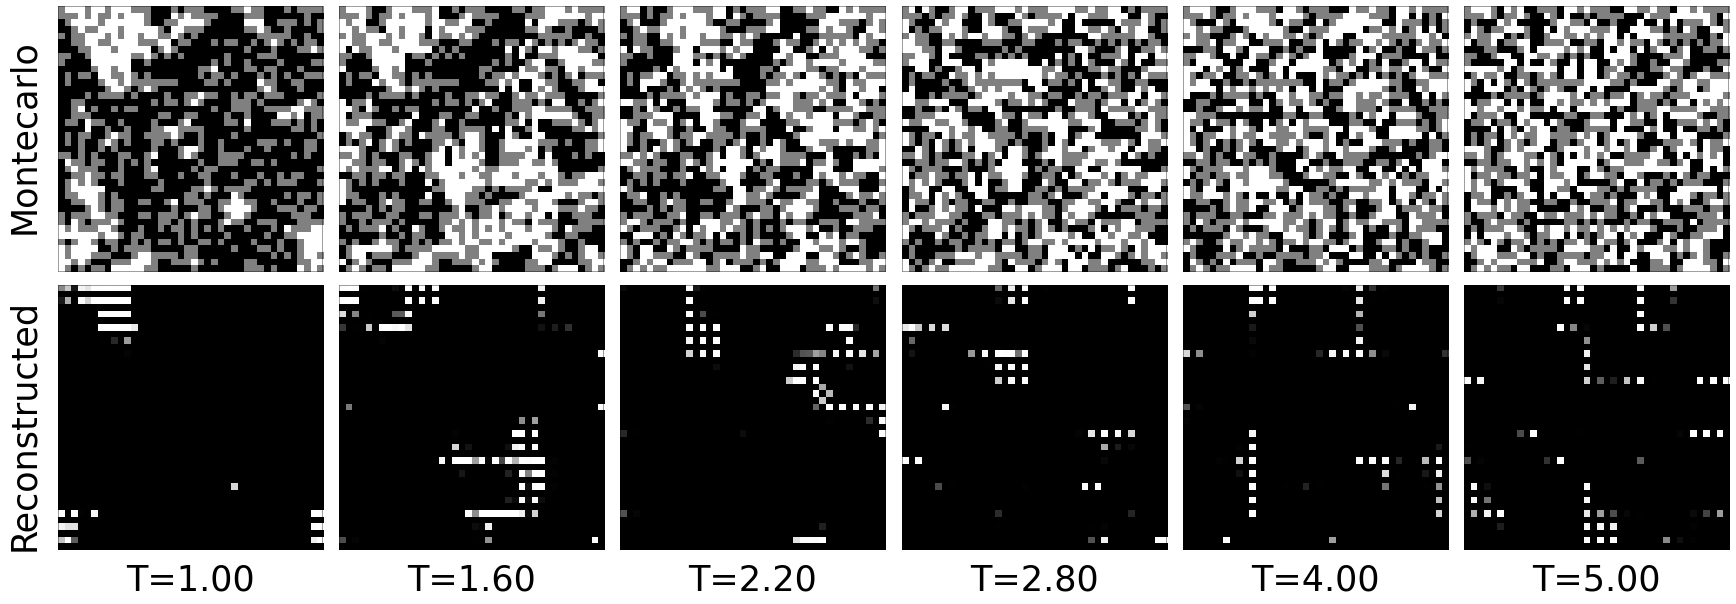

Loading simulated images...


Loading arrays: 100%|██████████| 151/151 [00:07<00:00, 21.30array/s]


Files loaded!
Data of density p = 0.7 succesfully loaded.


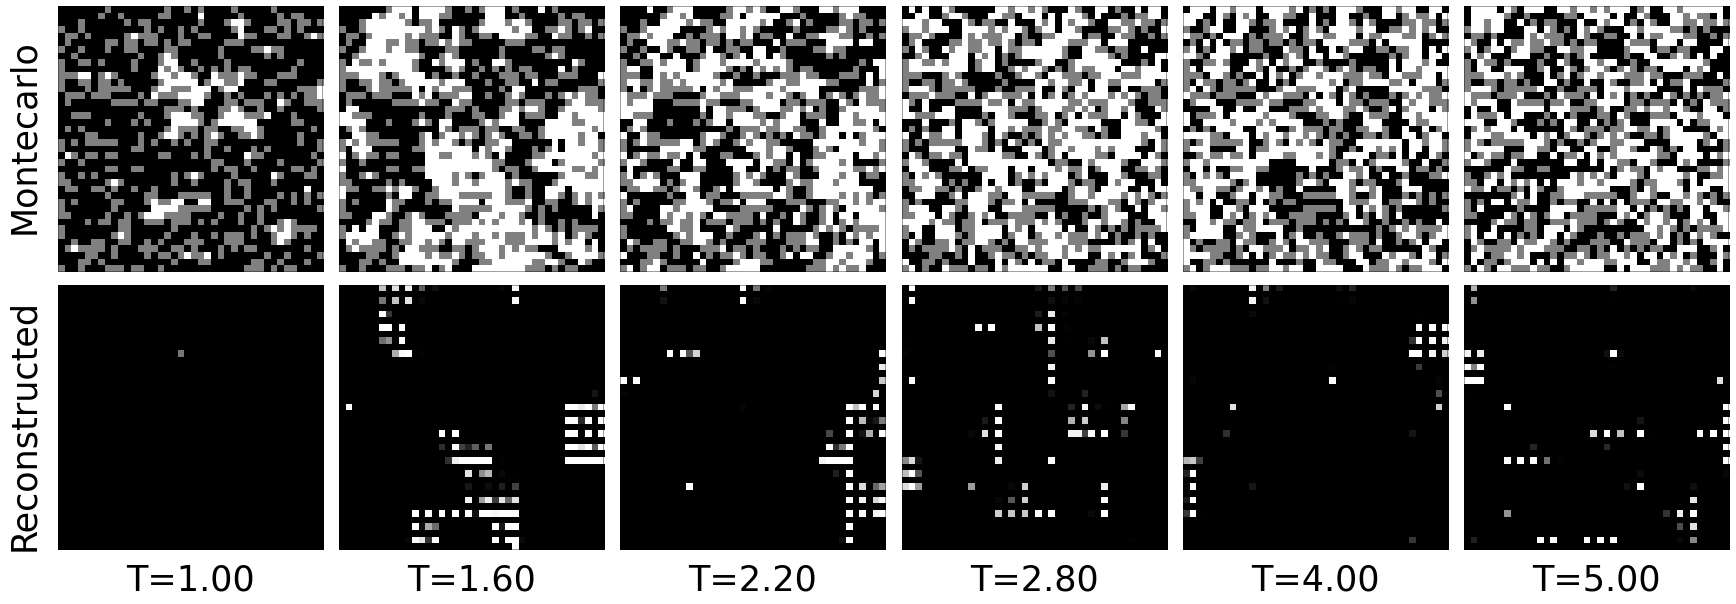

Loading simulated images...


Loading arrays: 100%|██████████| 155/155 [00:05<00:00, 28.99array/s]


Files loaded!
Data of density p = 0.8 succesfully loaded.


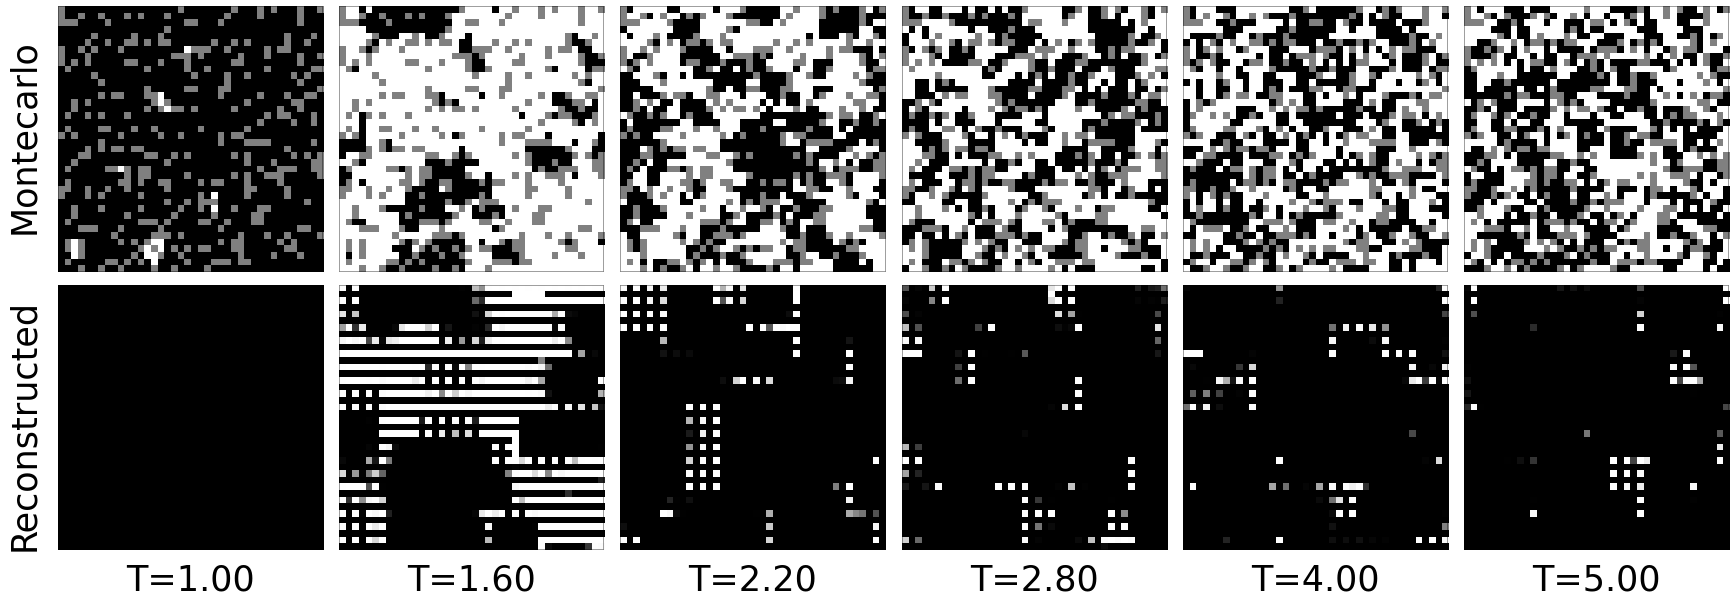

Loading simulated images...


Loading arrays: 100%|██████████| 139/139 [00:09<00:00, 14.81array/s]


Files loaded!
Data of density p = 0.9 succesfully loaded.


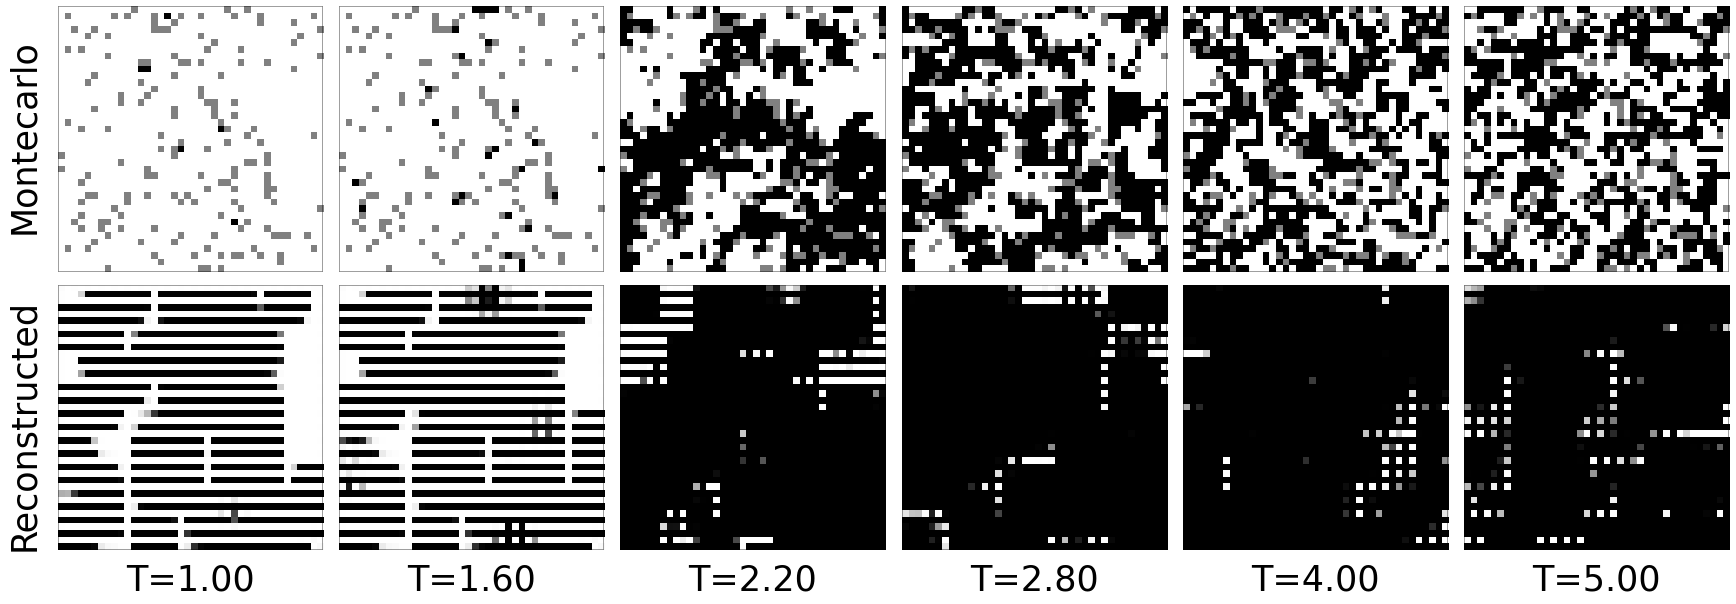

Loading simulated images...


Loading arrays: 100%|██████████| 156/156 [00:10<00:00, 14.53array/s]


Files loaded!
Data of density p = 1. succesfully loaded.


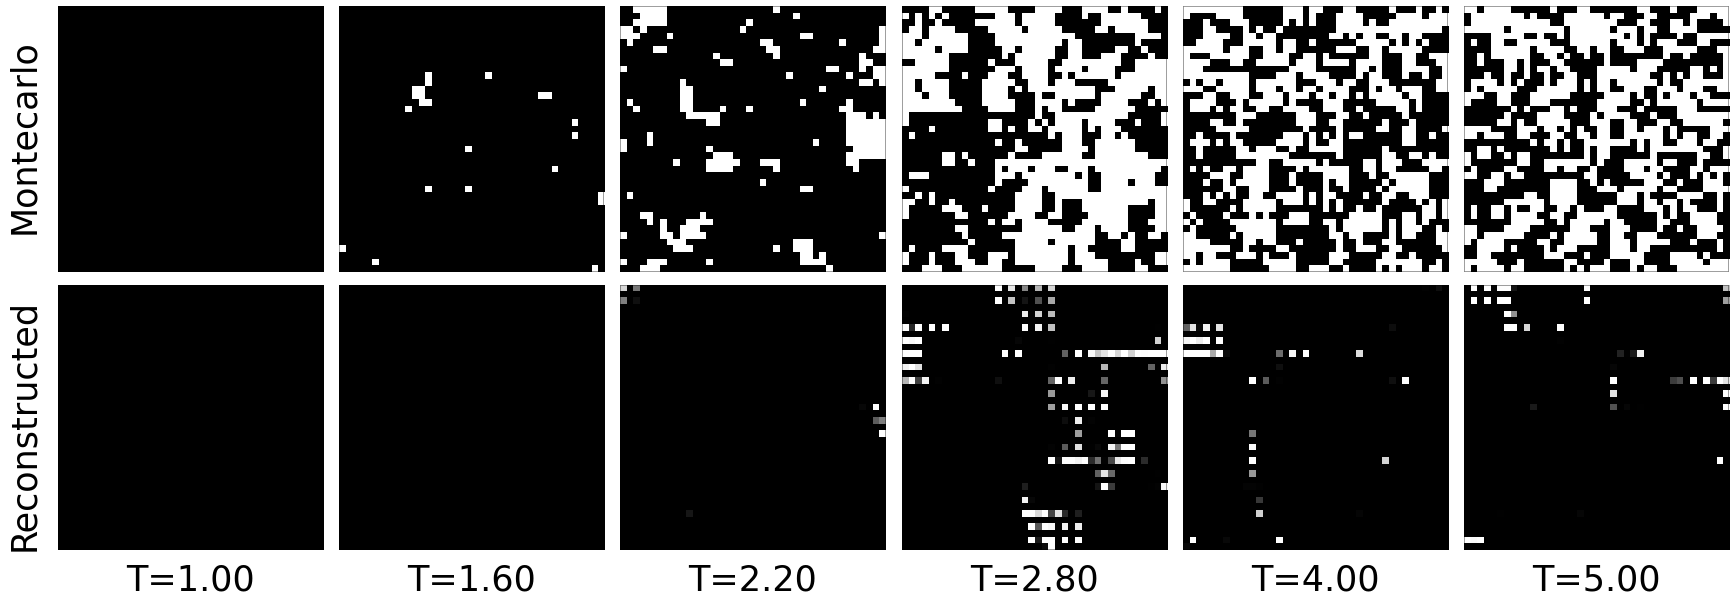

In [27]:
from matplotlib import colors
temperatures_sel = [50, 80, 110, 140, 200, 250]
n = len(temperatures_sel)

for i in range(11):
    fig, axes = plt.subplots(2, n, figsize=(30, 10), gridspec_kw={'wspace': 0.05, 'hspace': 0.05})

    sim_images, temperature = loader_init.simulatedImages(i)

    for j in range(n):
        prueba_sim = sim_images[0][temperatures_sel[j]].reshape(L, L)
        prueba_pred = pred_cae[i][temperatures_sel[j], 0, :, :, :].reshape(L, L)
        prueba_pred[prueba_pred == 0] = 1e-33

        # Primera fila (Montecarlo)
        ax = axes[0, j]
        ax.imshow(prueba_sim, cmap='gray', vmin=-1, vmax=1)
        ax.axis("off")
        rect = patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes,
                            linewidth=1.5, edgecolor='black', facecolor='none', alpha=0.5)
        ax.add_patch(rect)


        # Segunda fila (Reconstrucción)
        ax = axes[1, j]
        ax.imshow(prueba_pred, cmap='gray', vmin=0, vmax=1)#, norm=colors.LogNorm(vmin=1e-33, vmax=1))
        ax.axis("off")
        rect = patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes,
                            linewidth=1.5, edgecolor='black', facecolor='none', alpha=0.5)
        ax.add_patch(rect)


        # Agregar T=Tc debajo de la última fila
        axes[1, j].text(0.5, -0.15, f"T={temperature[temperatures_sel[j]]:.2f}",
                        fontsize=35, ha="center", transform=ax.transAxes)

    # Agregar etiquetas a la izquierda de cada fila
    fig.text(0.11, 0.70, "Montecarlo", fontsize=35, ha="center", va="center", rotation=90)
    fig.text(0.11, 0.30, "Reconstructed", fontsize=35, ha="center", va="center", rotation=90)

    plt.savefig(os.path.join(folder_figs, f'reconstrucciones_cae_{densities_str[i]}.pdf'), bbox_inches='tight')
    plt.show()


Loading simulated images...


Loading arrays: 100%|██████████| 196/196 [00:01<00:00, 118.35array/s]


Files loaded!
Data of density p = 0.55 succesfully loaded.


Calculating errors: 100%|██████████| 251/251 [05:54<00:00,  1.41s/Temperature]


(196, 251)


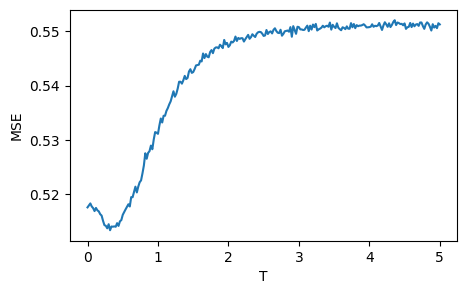

Loading simulated images...


Loading arrays: 100%|██████████| 150/150 [00:01<00:00, 83.98array/s]


Files loaded!
Data of density p = 0.6 succesfully loaded.


Calculating errors: 100%|██████████| 251/251 [04:29<00:00,  1.07s/Temperature]


(150, 251)


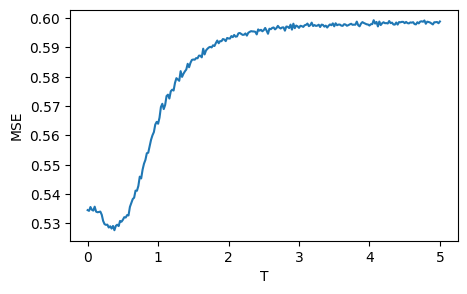

Loading simulated images...


Loading arrays: 100%|██████████| 199/199 [00:01<00:00, 118.69array/s]


Files loaded!
Data of density p = 0.61 succesfully loaded.


Calculating errors: 100%|██████████| 251/251 [06:00<00:00,  1.44s/Temperature]


(199, 251)


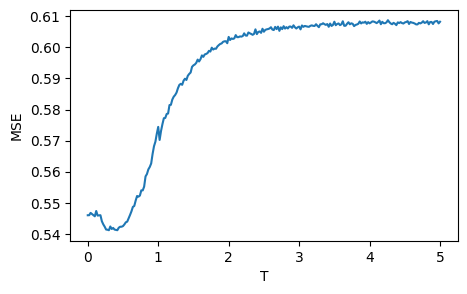

Loading simulated images...


Loading arrays: 100%|██████████| 187/187 [00:01<00:00, 122.32array/s]


Files loaded!
Data of density p = 0.62 succesfully loaded.


Calculating errors: 100%|██████████| 251/251 [05:31<00:00,  1.32s/Temperature]


(187, 251)


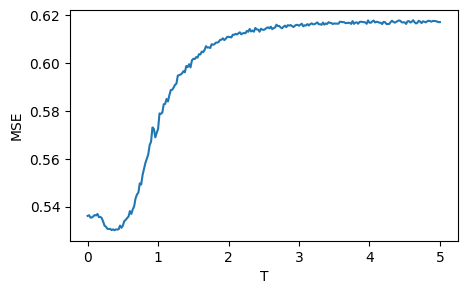

Loading simulated images...


Loading arrays: 100%|██████████| 163/163 [00:02<00:00, 72.56array/s] 


Files loaded!
Data of density p = 0.63 succesfully loaded.


Calculating errors: 100%|██████████| 251/251 [04:50<00:00,  1.16s/Temperature]


(163, 251)


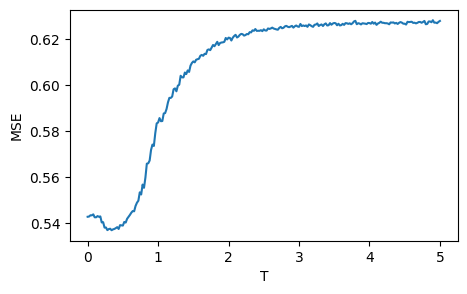

Loading simulated images...


Loading arrays: 100%|██████████| 142/142 [00:01<00:00, 84.98array/s]


Files loaded!
Data of density p = 0.64 succesfully loaded.


Calculating errors: 100%|██████████| 251/251 [04:15<00:00,  1.02s/Temperature]


(142, 251)


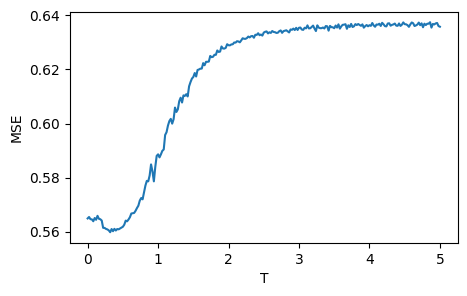

Loading simulated images...


Loading arrays: 100%|██████████| 161/161 [00:01<00:00, 83.46array/s]


Files loaded!
Data of density p = 0.65 succesfully loaded.


Calculating errors: 100%|██████████| 251/251 [04:48<00:00,  1.15s/Temperature]


(161, 251)


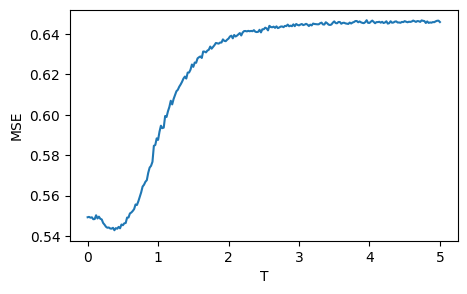

Loading simulated images...


Loading arrays: 100%|██████████| 151/151 [00:01<00:00, 113.31array/s]


Files loaded!
Data of density p = 0.7 succesfully loaded.


Calculating errors: 100%|██████████| 251/251 [04:31<00:00,  1.08s/Temperature]


(151, 251)


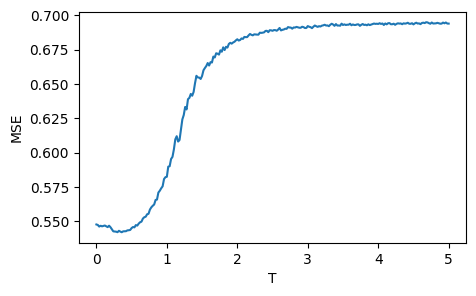

Loading simulated images...


Loading arrays: 100%|██████████| 155/155 [00:01<00:00, 87.02array/s]


Files loaded!
Data of density p = 0.8 succesfully loaded.


Calculating errors: 100%|██████████| 251/251 [04:38<00:00,  1.11s/Temperature]


(155, 251)


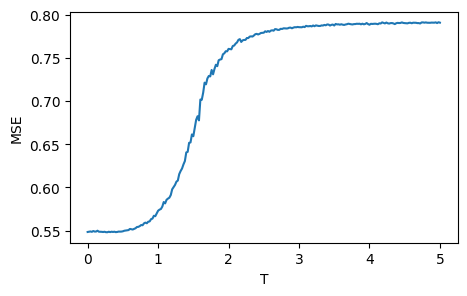

Loading simulated images...


Loading arrays: 100%|██████████| 139/139 [00:01<00:00, 117.56array/s]


Files loaded!
Data of density p = 0.9 succesfully loaded.


Calculating errors: 100%|██████████| 251/251 [04:12<00:00,  1.00s/Temperature]


(139, 251)


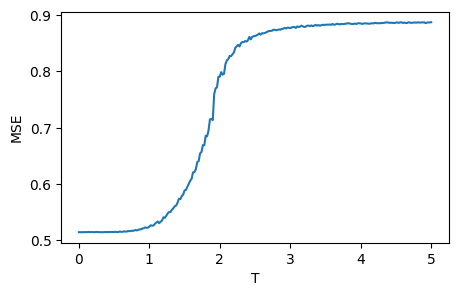

Loading simulated images...


Loading arrays: 100%|██████████| 156/156 [00:01<00:00, 116.27array/s]


Files loaded!
Data of density p = 1. succesfully loaded.


Calculating errors: 100%|██████████| 251/251 [04:39<00:00,  1.11s/Temperature]


(156, 251)


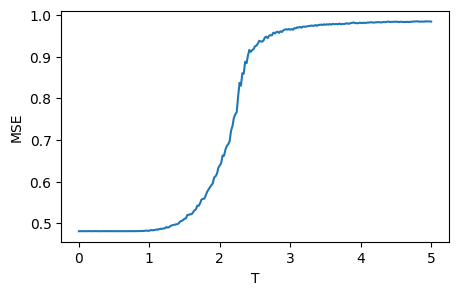

In [ ]:
mse = losses.MeanSquaredError()

for density in densities:
	index = densities.index(density)
	sim_images, temperature = loader_init.simulatedImages(index)
	errores = []

	auto = tf.keras.models.load_model(f'auto_n8.h5')

	all_errors = []

	for temp in tqdm(range(251), desc="Calculating errors", unit="Temperature"):

		original_T = np.array(sim_images)[:,temp,:,:].copy()

		reconstruida_T = auto.predict(original_T, verbose = False)

		all_errors1 = []

		errorT = 0.0
		for mc in range(len(original_T)):

			errorT += mse(original_T[mc],reconstruida_T[mc]).numpy()
			error1 = mse(original_T[mc],reconstruida_T[mc]).numpy()
			all_errors1.append(error1)
		all_errors1 = np.array(all_errors1).reshape(len(all_errors1),1)
		all_errors.append(all_errors1)

		errorT = errorT/len(original_T)

		errores.append(errorT)

	all_data = np.hstack(all_errors)
	print(all_data.shape)
	all_data = pd.DataFrame(all_data)
	all_data.to_csv( f'all_data_p{str(density)}.csv', index=False)

	prediction = pd.DataFrame((np.concatenate((np.array(temperature).reshape(len(temperature),1),
			np.array(errores).reshape(len(errores),1)),axis=1)), columns=['Temperature','Errors'])
	prediction.to_csv( f'errors_p{str(density)}.csv', index=False)

	plt.figure(figsize = (5, 3))
	plt.plot(temperature,errores)
	plt.xlabel('T')
	plt.ylabel('MSE')
	plt.savefig(os.path.join(folder_figs, f'errors_p{str(density)}.pdf'))
	plt.show()

Los archivos "all_data_i" contienen todas las curvas de errores de recontrucción para todas las repeticiones.

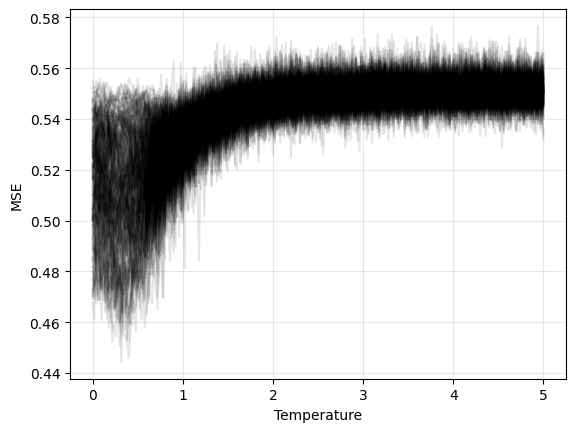

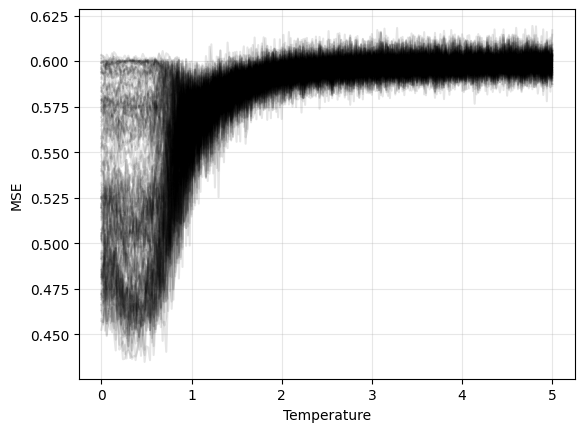

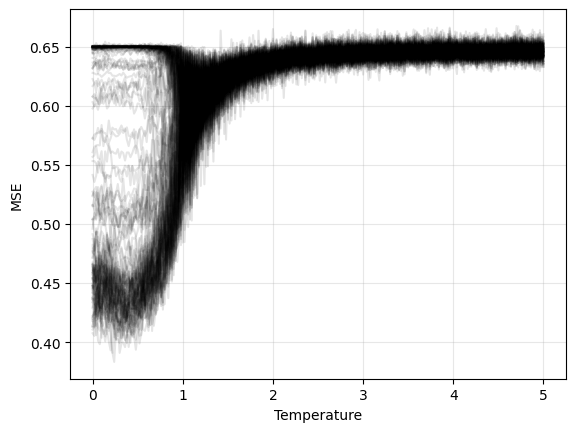

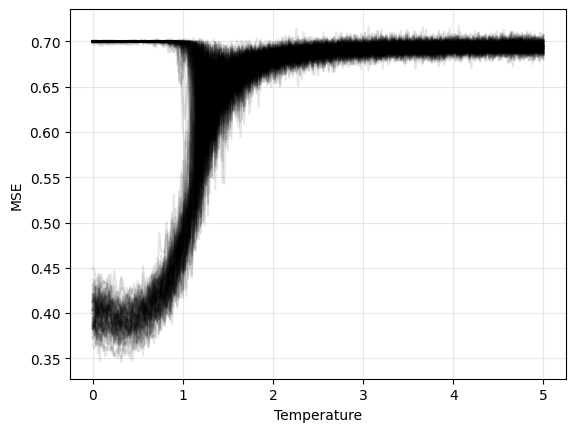

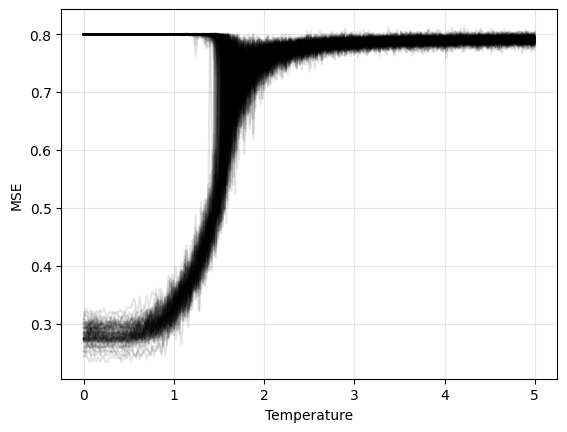

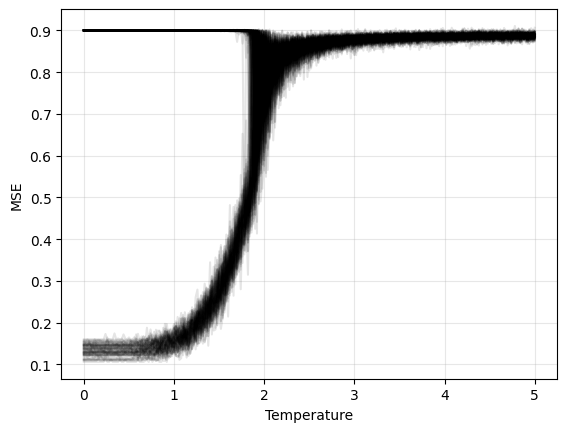

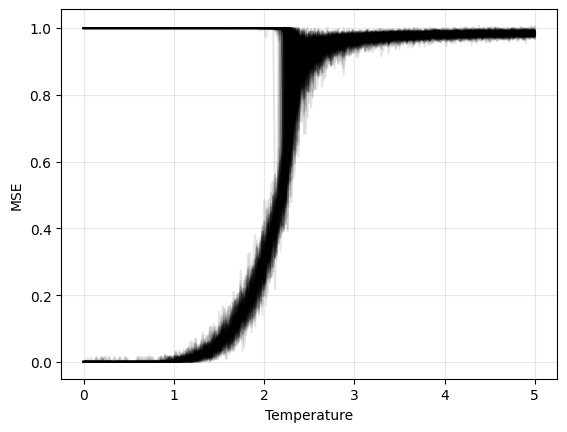

In [ ]:
for density in densities:
	all_data = pd.read_csv(os.path.join(folder, f'all_data_p{density}.csv'))
	all_data = all_data.T

	plt.figure()#figsize=(8, 6))
	for i in range(all_data.shape[1]):
		plt.plot(temperatures, all_data.to_numpy()[:, i], color='k', alpha=0.1)
		#plt.title(f'Density {density}')
		plt.xlabel('Temperature')
		plt.ylabel('MSE')
		plt.grid(alpha=0.3)
	plt.savefig(os.path.join(folder_figs, f'all_data_p{density}.pdf'))
	plt.show()

# Clusters

Cargamos "all_data" y "pred_cae" para cada densidad. En estos archivos tenemos las curvas de error de reconstrucción y cada reconstrucción, respectivamente. Vamos a calcular la magnetización de las 20 primeras reconstrucciones y realizar una clusterización de las curvas.

In [ ]:
data = pd.read_csv(os.path.join(folder, "all_data_p0.55.csv"))
data = np.array(data)

In [ ]:
print(data.shape)
print(pred_cae[0].shape)

(196, 251)
(251, 196, 40, 40, 1)


In [ ]:
mag_reconstrucciones = np.sum(pred_cae[0], axis=(2, 3, 4)) / (40 * 40)
mag_reconstrucciones = mag_reconstrucciones.T
print(mag_reconstrucciones.shape)

(196, 251)


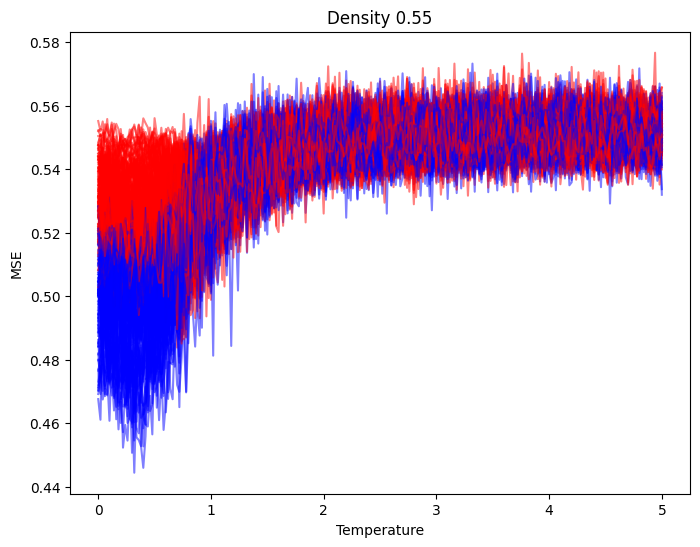

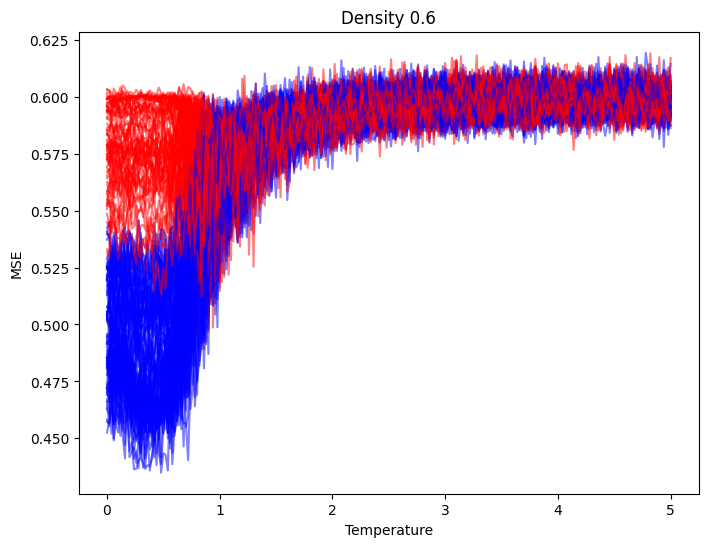

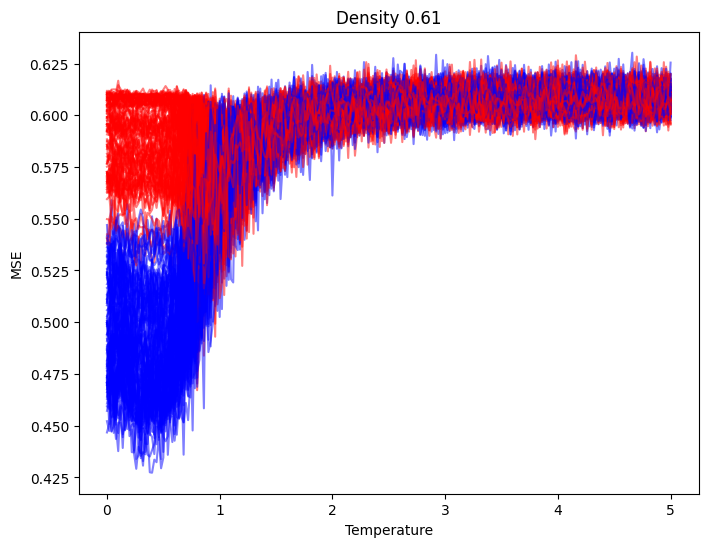

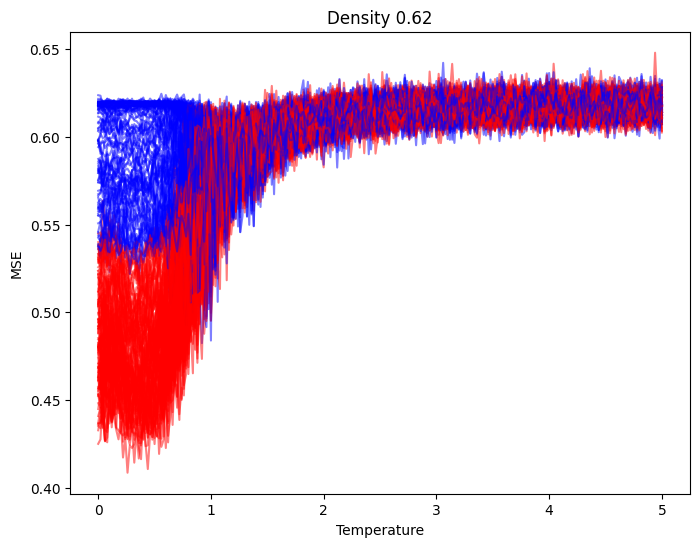

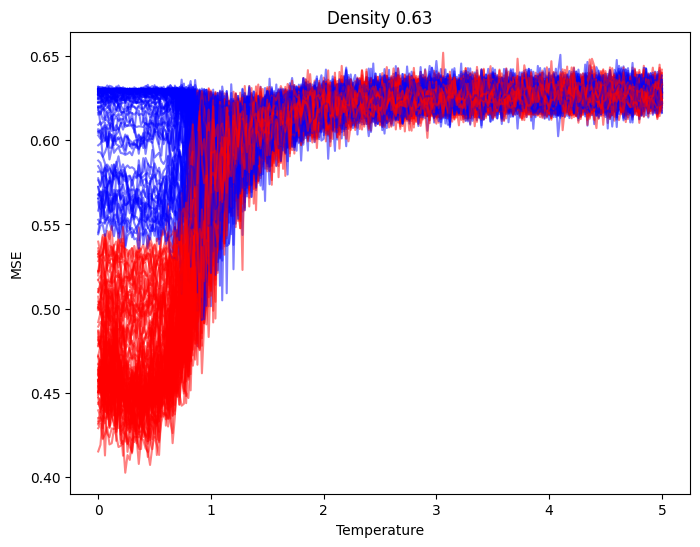

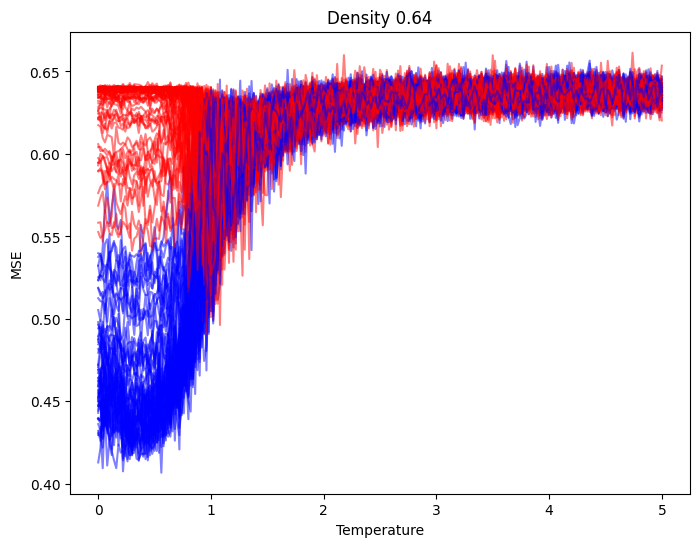

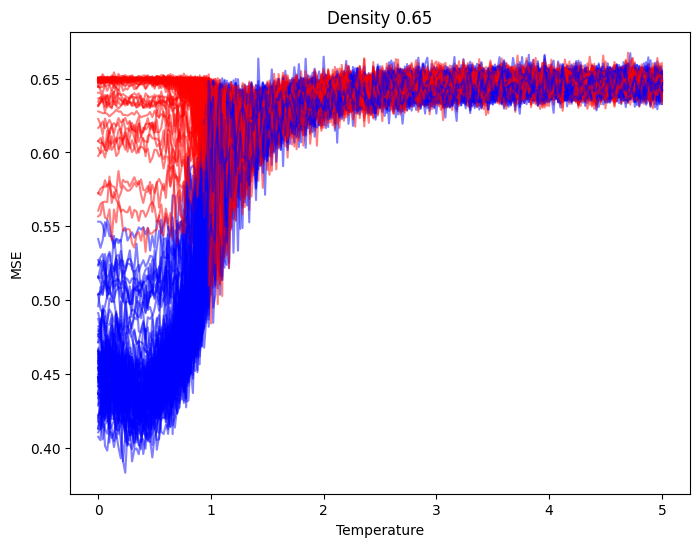

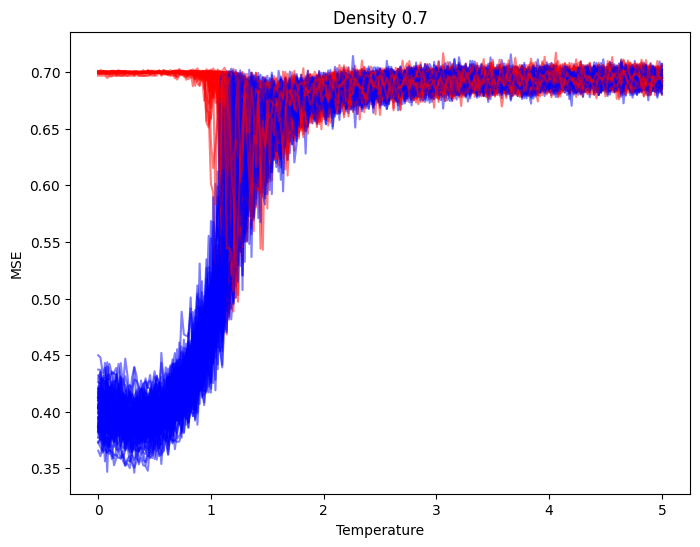

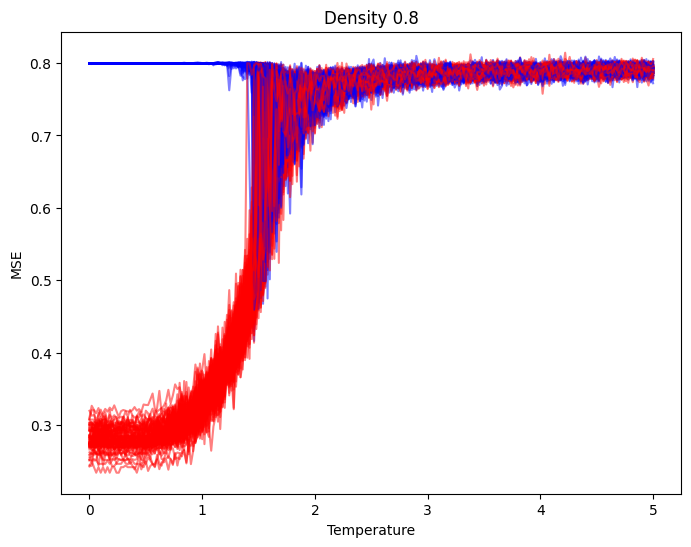

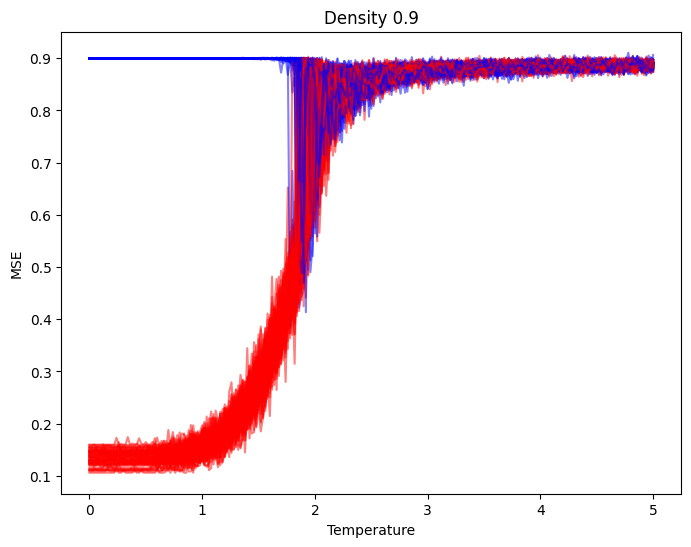

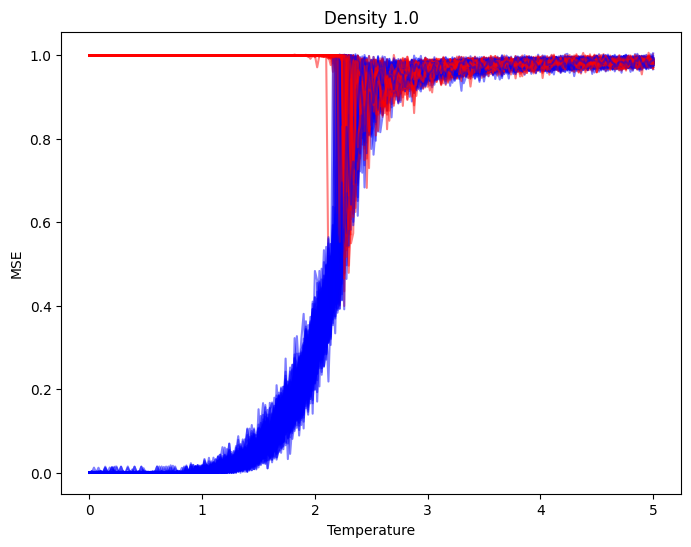

In [ ]:
for density in densities:
	data = pd.read_csv(os.path.join(folder, f"all_data_p{density}.csv"))
	data = np.array(data)
	den = densities.index(density)
	predictions_cae = pred_cae[den]
	low_temp_data = data[:, :20]  # Shape (20, 150)

	mag_reconstrucciones = np.sum(predictions_cae, axis=(2, 3, 4)) / (40 * 40)
	mag_reconstrucciones = mag_reconstrucciones.T

	#low_temp_data = mag_reconstrucciones[:, :20]  # Shape (20, 150)

	# Apply k-means clustering (2 clusters)
	kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
	clusters = kmeans.fit_predict(low_temp_data)  # Shape (150,)

	# Plot results
	plt.figure(figsize=(8, 6))
	for i in range(data.shape[0]):  # Iterate over 150 curves
		plt.plot(temperatures, data[i, :], color="red" if clusters[i] == 0 else "blue", alpha=0.5)

	plt.xlabel("Temperature")
	plt.ylabel("MSE")
	plt.title(f"Density {density}")
	plt.savefig(os.path.join(folder_figs, f'clusters_p{density}.pdf'))
	plt.show()


Separamos los clusters y calculamos, para cada uno de ellos, su promedio y desviación.

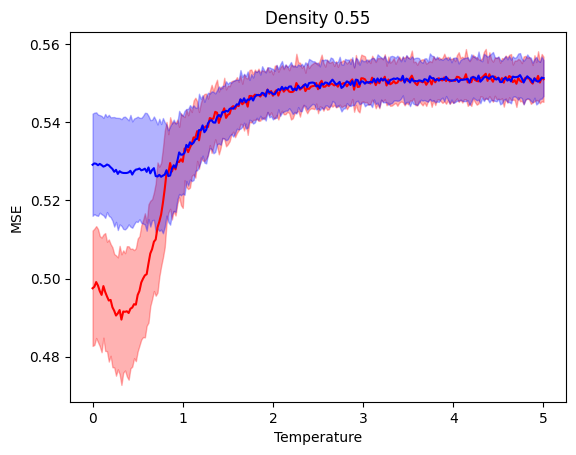

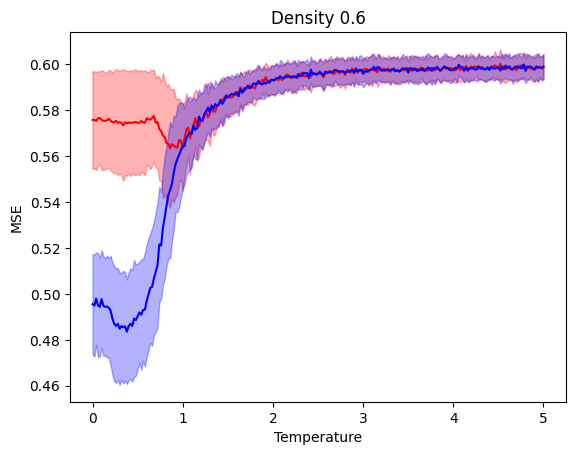

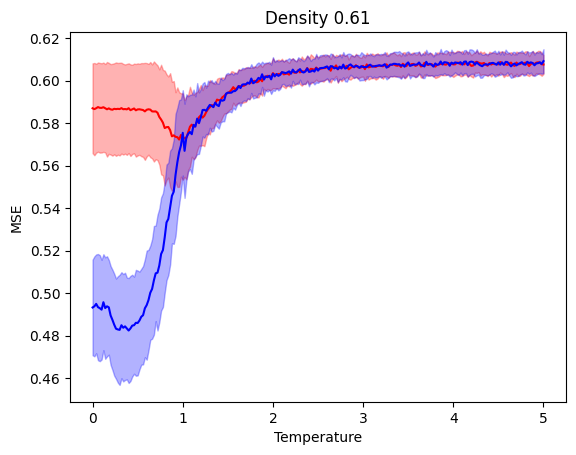

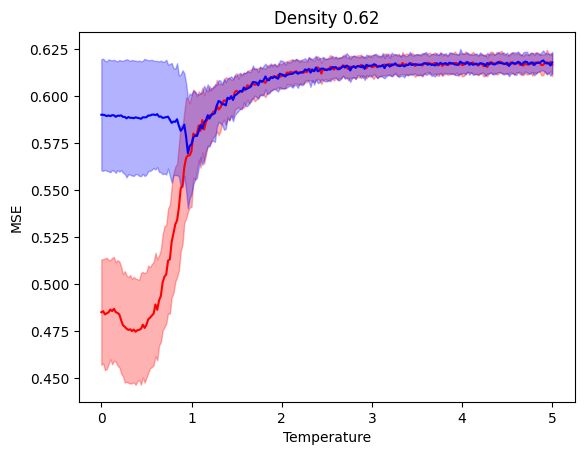

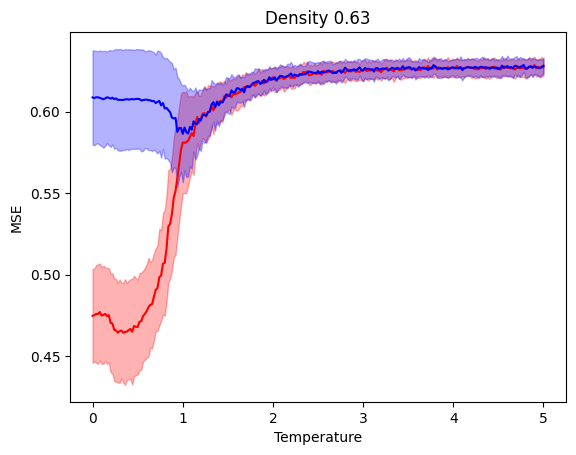

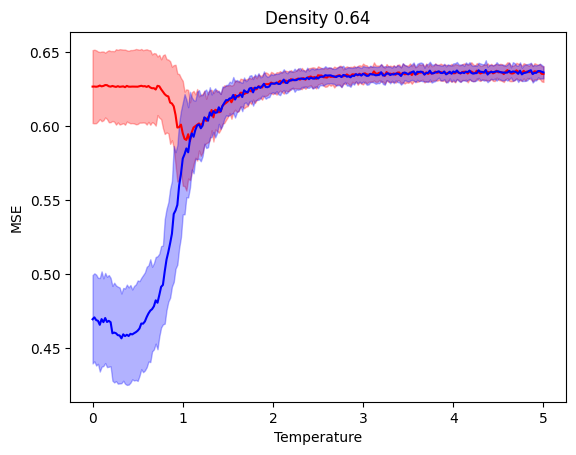

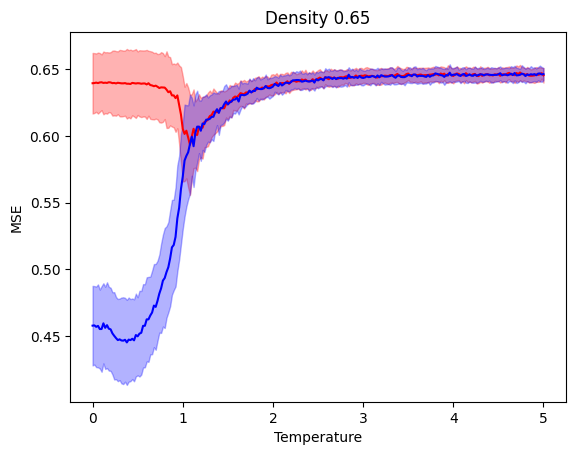

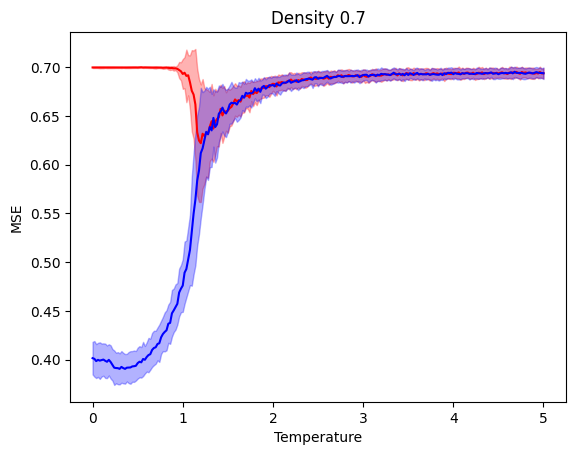

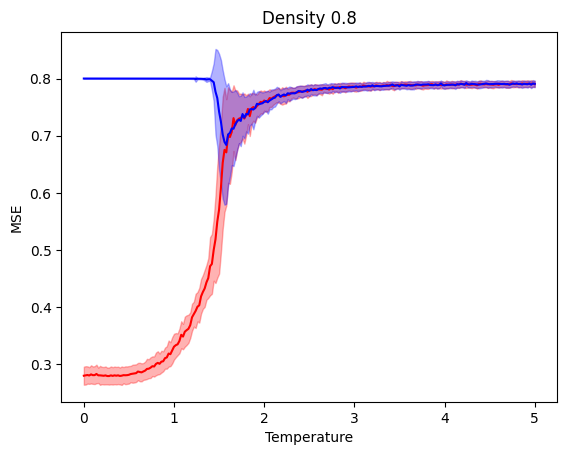

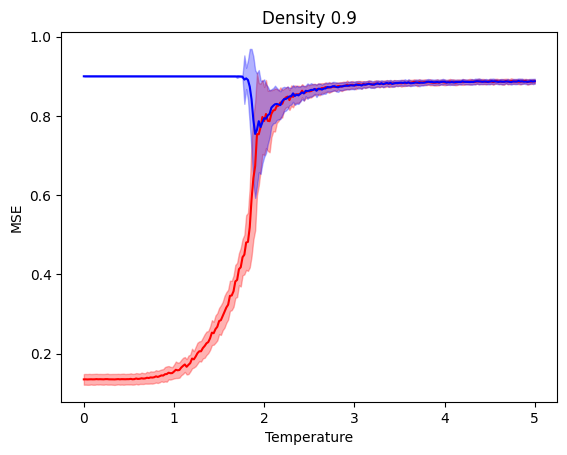

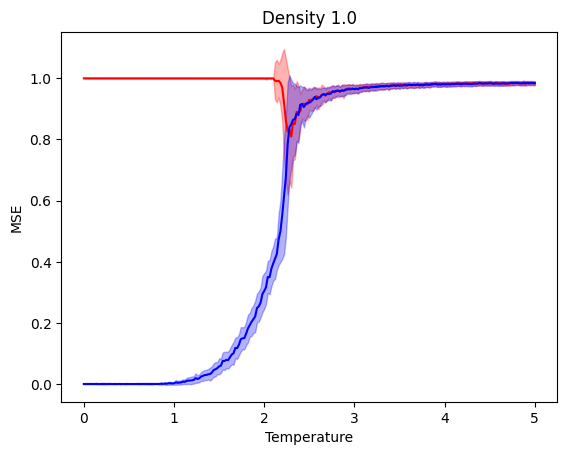

In [ ]:
for density in densities:
	data = pd.read_csv(os.path.join(folder, f"all_data_p{density}.csv"))
	data = np.array(data)
	den = densities.index(density)
	predictions_cae = pred_cae[den]

	mag_reconstrucciones = np.sum(predictions_cae, axis=(2, 3, 4)) / (40 * 40)
	mag_reconstrucciones = mag_reconstrucciones.T

	low_temp_data = mag_reconstrucciones[:, :20]  # Shape (20, 150)

	# Apply k-means clustering (2 clusters)
	kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
	clusters = kmeans.fit_predict(low_temp_data)  # Shape (150,)

	mag1 = []
	mag2 = []
	for i in range(data.shape[0]):
		if clusters[i] == 0:
			mag1.append(data[i, :])
		else:
			mag2.append(data[i, :])
	mag1 = np.array(mag1)
	mag2 = np.array(mag2)

	mag1_mean = np.mean(mag1, axis=0)
	mag2_mean = np.mean(mag2, axis=0)

	mag1_std = np.std(mag1, axis=0)
	mag2_std = np.std(mag2, axis=0)

	# Plot mean curve
	plt.plot(temperatures, mag1_mean, color='red', label='Magnetization state 1')
	plt.plot(temperatures, mag2_mean, color='blue', label='Magnetization state 2')

	# Plot shaded error region (mean ± 1 std)
	plt.fill_between(temperatures, mag1_mean - mag1_std, mag1_mean + mag1_std,
					color='red', alpha=0.3, label='Magnetization state 1')
	plt.fill_between(temperatures, mag2_mean - mag2_std, mag2_mean + mag2_std,
					color='blue', alpha=0.3, label='Magnetization state 2')
	#plt.plot(temperatures, std_curve, label='Standard Deviation', color='red')


	plt.xlabel("Temperature")
	plt.ylabel("MSE")
	plt.title(f"Density {density}")
	plt.savefig(os.path.join(folder_figs, f'mean_clusters_p{density}.pdf'))
	plt.show()

Probamos con dos sigmas.

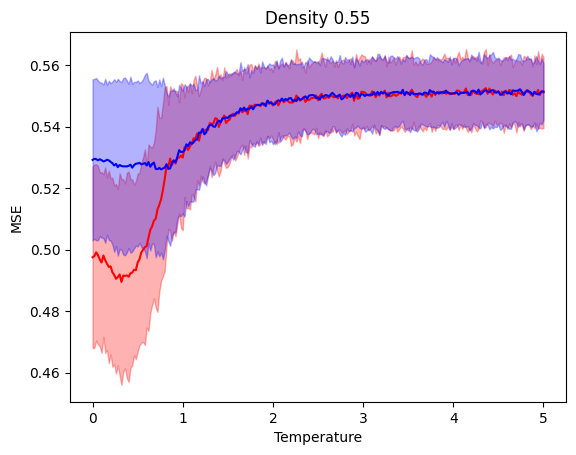

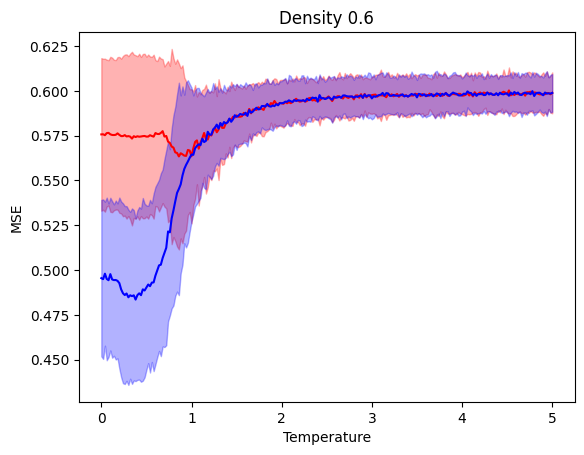

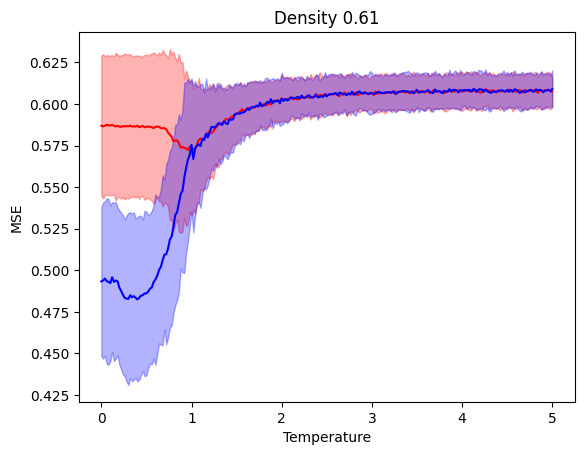

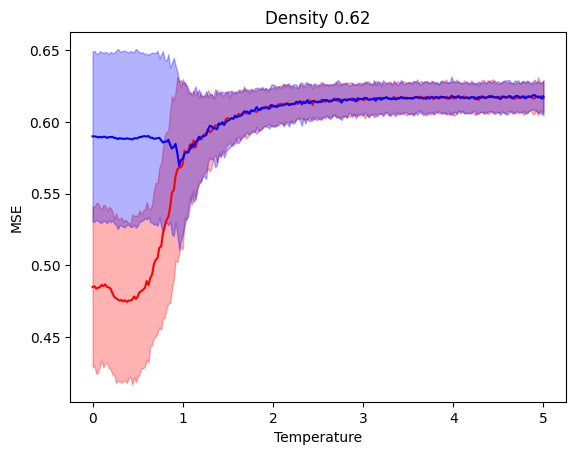

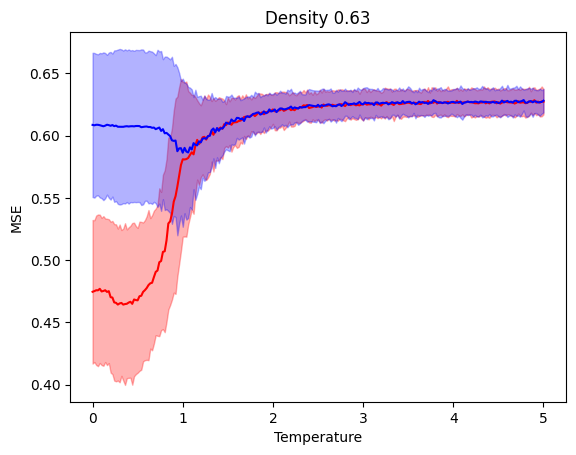

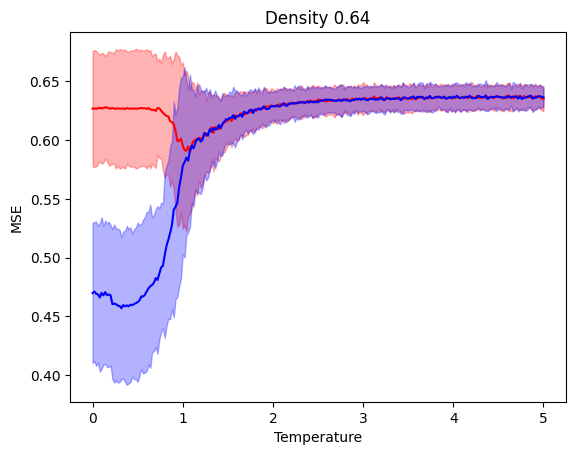

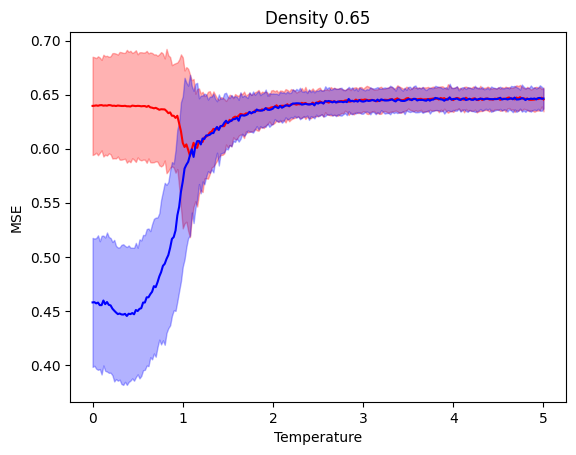

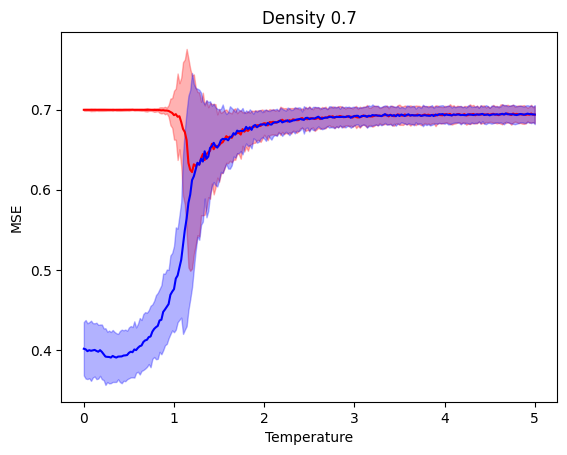

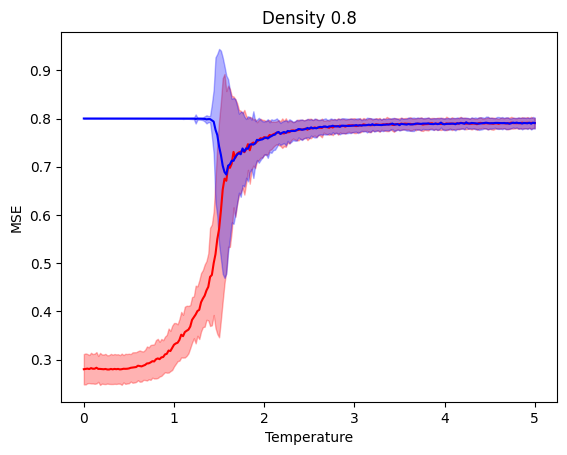

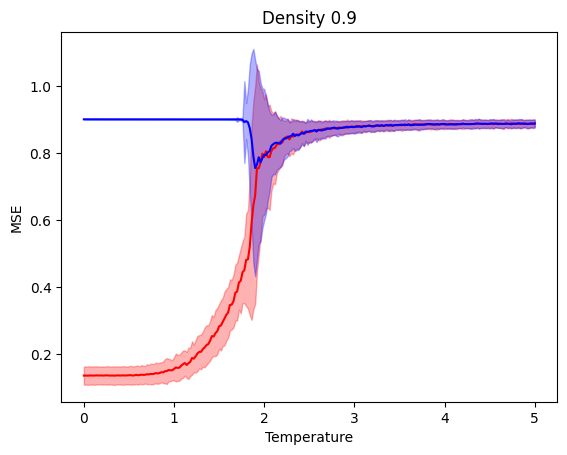

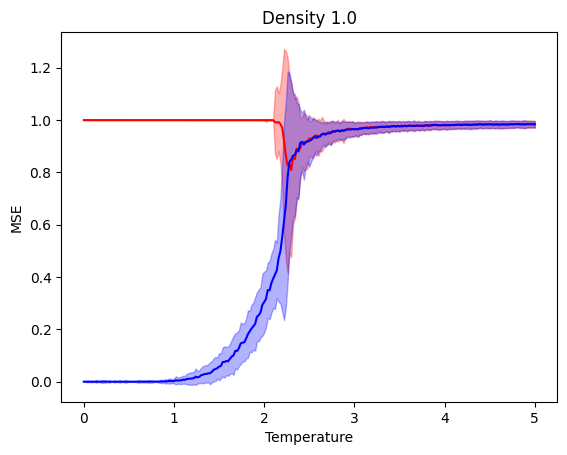

In [ ]:
critical_temp_mag1 = []
critical_temp_mag2 = []

for density in densities:
	data = pd.read_csv(os.path.join(folder, f"all_data_p{density}.csv"))
	data = np.array(data)
	den = densities.index(density)
	predictions_cae = pred_cae[den]

	mag_reconstrucciones = np.sum(predictions_cae, axis=(2, 3, 4)) / (40 * 40)
	mag_reconstrucciones = mag_reconstrucciones.T

	low_temp_data = mag_reconstrucciones[:, :20]  # Shape (20, 150)

	# Apply k-means clustering (2 clusters)
	kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
	clusters = kmeans.fit_predict(low_temp_data)  # Shape (150,)

	mag1 = []
	mag2 = []
	for i in range(data.shape[0]):
		if clusters[i] == 0:
			mag1.append(data[i, :])
		else:
			mag2.append(data[i, :])
	mag1 = np.array(mag1)
	mag2 = np.array(mag2)

	mag1_mean = np.mean(mag1, axis=0)
	mag2_mean = np.mean(mag2, axis=0)

	mag1_std = np.std(mag1, axis=0)
	mag2_std = np.std(mag2, axis=0)

	critical_temp_mag1.append(temperatures[np.argmax(mag1_std)])
	critical_temp_mag2.append(temperatures[np.argmax(mag2_std)])

	# Plot mean curve
	plt.plot(temperatures, mag1_mean, color='red', label='Magnetization state 1')
	plt.plot(temperatures, mag2_mean, color='blue', label='Magnetization state 2')

	# Plot shaded error region (mean ± 1 std)
	plt.fill_between(temperatures, mag1_mean - 2*mag1_std, mag1_mean + 2*mag1_std,
					color='red', alpha=0.3, label='Magnetization state 1')
	plt.fill_between(temperatures, mag2_mean - 2*mag2_std, mag2_mean + 2*mag2_std,
					color='blue', alpha=0.3, label='Magnetization state 2')
	#plt.plot(temperatures, std_curve, label='Standard Deviation', color='red')


	plt.xlabel("Temperature")
	plt.ylabel("MSE")
	plt.title(f"Density {density}")
	plt.savefig(os.path.join(folder_figs, f'2sigmas_clusters_p{density}.pdf'))
	plt.show()

# Critical temperatures

In [ ]:
critical_temp_mag1 = np.array(critical_temp_mag1)
critical_temp_mag2 = np.array(critical_temp_mag2)

print(critical_temp_mag1)
print(critical_temp_mag2)


[0.4  0.78 0.8  0.88 0.92 0.94 1.   1.16 1.54 1.9  2.26]
[0.6  0.86 0.92 0.78 0.94 0.9  1.02 1.14 1.54 1.9  2.26]


In [ ]:
crit_temp1 = pd.DataFrame(critical_temp_mag1)
crit_temp1.to_csv(os.path.join(folder, f'cae_critical_temp_mag1.csv'), index=False)

crit_temp2 = pd.DataFrame(critical_temp_mag2)
crit_temp2.to_csv(os.path.join(folder, f'cae_critical_temp_mag2.csv'), index=False)

In [ ]:
# Loading critical temperatures

cae_pred_1 = pd.read_csv(os.path.join(folder, f'cae_critical_temp_mag1.csv'))#.to_numpy()
cae_pred_1 = np.array(cae_pred_1)

cae_pred_2 = pd.read_csv(os.path.join(folder, f'cae_critical_temp_mag2.csv')).to_numpy()
cae_pred_2 = np.array(cae_pred_2)

dnn_pred = pd.read_csv(os.path.join(folder,"dnn_predictions.csv"))
dnn_pred = np.array(dnn_pred)
densities = dnn_pred[:, 0]
dnn_pred = dnn_pred[:, 1]

Según el criterio de $2\sigma$ podemos identificar temperaturas de transición solo a densidades mayores a $\rho = 0.62$, por lo tanto, ponemos $T_c(\rho = 0.55) = 0$

In [ ]:
for i in range(len(densities)):
	if densities[i] < 0.6:
		cae_pred_1[i] = 0
		cae_pred_2[i] = 0

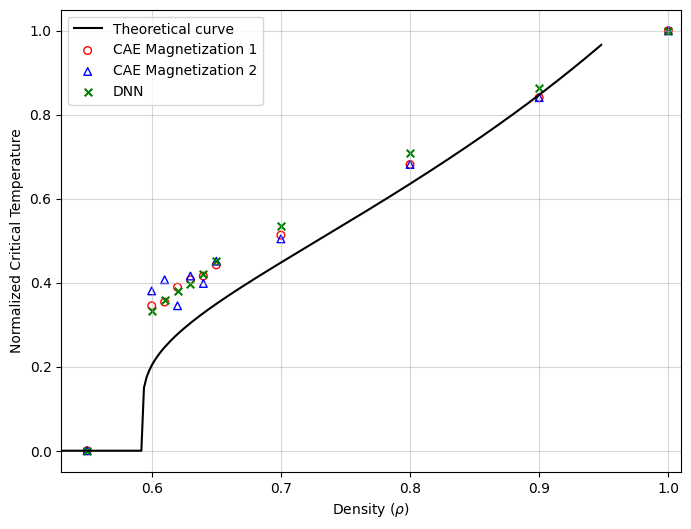

In [ ]:
plt.figure(figsize=(8, 6))

densi = np.arange(0.0,0.95,0.002)
curva = densi*0
for i in range(len(densi)):
    if densi[i]<0.592746:
        curva[i] = 0
    else:
        curva[i] = -1.0/(np.log(densi[i]-0.592746))

plt.plot(densi, curva, color='k', label='Theoretical curve')


plt.scatter(densities, cae_pred_1/np.max(cae_pred_1), marker = 'o', s=30, label='CAE Magnetization 1', color='red', facecolors='none')
plt.scatter(densities, cae_pred_2 / np.max(cae_pred_2), marker = '^', s=30, label='CAE Magnetization 2', color='blue', facecolors='none')
plt.scatter(densities, dnn_pred / np.max(dnn_pred), marker = 'x', s=30, label='DNN', color='green')
plt.xlabel(r'Density ($\rho$)')
plt.ylabel('Normalized Critical Temperature')
plt.xlim(0.53, 1.01)
plt.grid(alpha=0.5)
plt.legend()

plt.savefig(os.path.join(folder_figs, f'cae_dnn_percolation.pdf'))
plt.show()


In [ ]:
cae_pred_1

array([[0.  ],
       [0.78],
       [0.8 ],
       [0.88],
       [0.92],
       [0.94],
       [1.  ],
       [1.16],
       [1.54],
       [1.9 ],
       [2.26]])

In [ ]:
from scipy.optimize import curve_fit

def model_function(x, A, B, K):
	return - K/np.log(x-B) + A

initial_guesses = [0.0, 0.592746, 1.0]

popt, pcov = curve_fit(model_function, densities[1:], dnn_pred[1:] / np.max(dnn_pred), p0=initial_guesses)

print(popt)
print(pcov)

print(np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2]))

sim_density = np.arange(0.6,1.002,0.002)

# Fitting parameters of theoretical curve
x_curve = np.arange(0.0,0.602,0.002)
y_curve = x_curve*0
y_curve[-1] = model_function(sim_density[1], *popt)



[0.18767008 0.59667331 0.77071008]
[[ 5.67938342e-04  9.78227866e-05 -5.59815722e-04]
 [ 9.78227866e-05  2.82471974e-05 -5.81526483e-05]
 [-5.59815722e-04 -5.81526483e-05  8.93106650e-04]]
0.023831456985777214 0.005314809253501838 0.02988488999704462


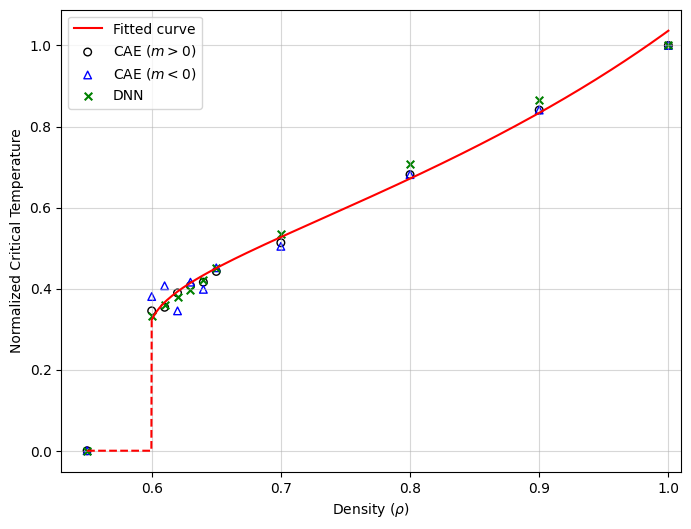

In [ ]:
def func(x):
	funcion = x.copy()
	for i in range(len(x)):
		if x[i] < 0.6:
			funcion[i]=0
		else:
			funcion[i]=0.32
	return funcion

plt.figure(figsize=(8, 6))

x_int= np.linspace(0.55, 0.6, 200)

plt.plot(sim_density, model_function(sim_density, *popt),'r', label = 'Fitted curve')
plt.plot(x_int, func(x_int), '--', color='r')
plt.scatter(densities, cae_pred_1/np.max(cae_pred_1), marker = 'o', s=30, label='CAE ($m>0$)', color='k', facecolors='none')
plt.scatter(densities, cae_pred_2 / np.max(cae_pred_2), marker = '^', s=30, label='CAE ($m<0$)', color='blue', facecolors='none')
plt.scatter(densities, dnn_pred / np.max(dnn_pred), marker = 'x', s=30, label='DNN', color='green')
plt.xlabel(r'Density ($\rho$)')
plt.ylabel('Normalized Critical Temperature')
plt.xlim(0.53, 1.01)
plt.grid(alpha=0.5)
plt.legend()

plt.savefig(os.path.join(folder_figs, f'cae_dnn_percolation.pdf'))
plt.show()

# Comparación clusters-magnetización

En esta sección calculamos dos clusters usando K-means, pero sobre los errores de reconstrucción, no sobre las magnetizaciones. Y luego, comparamos, sobre esos clusters, cuánto error comete en la magnetización.

In [ ]:
densities = [0.55, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.7, 0.8, 0.9, 1.0]

for density in densities:
	data = pd.read_csv(os.path.join(folder, f"all_data_p{density}.csv"))
	data = np.array(data)
	den = densities.index(density)

	# Calculamos clusters

	low_temp_data = data[:, 20:40]

	kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
	clusters = kmeans.fit_predict(low_temp_data)

	# Calculamos la magnetización de cada curva
	sim_images, _ = loader_init.simulatedImages(den)

	mag_reconstrucciones = []
	for i in range(len(sim_images)):
		mag_reconstrucciones.append(np.sum(sim_images[i], axis=(1, 2)) / (40 * 40))
	mag_reconstrucciones = np.array(mag_reconstrucciones)

	magnetiz = []
	for i in range(mag_reconstrucciones.shape[0]):
		prom = np.mean(mag_reconstrucciones[i, 20:40])
		if prom > 0:
			magnetiz.append(1)
		else:
			magnetiz.append(0)
	magnetiz = np.array(magnetiz)

	# Chequeamos que coincidan las magnetizaciones con los clusters
	true_index = []
	for i in range(len(magnetiz)):
		if clusters[i] == magnetiz[i]:
			true_index.append(1)
		else:
			true_index.append(0)
	true_index = np.array(true_index)
	true_mean = np.sum(true_index)/len(true_index)
	if true_mean >= 0.5:
		print(true_mean)
	else:
		print(1-true_mean)

Loading simulated images...


Loading arrays: 100%|██████████| 196/196 [00:01<00:00, 137.32array/s]


Files loaded!
Data of density p = 0.55 succesfully loaded.
0.9081632653061225
Loading simulated images...


Loading arrays: 100%|██████████| 150/150 [00:01<00:00, 136.38array/s]


Files loaded!
Data of density p = 0.6 succesfully loaded.
0.96
Loading simulated images...


Loading arrays: 100%|██████████| 199/199 [00:02<00:00, 84.44array/s]


Files loaded!
Data of density p = 0.61 succesfully loaded.
0.9899497487437185
Loading simulated images...


Loading arrays: 100%|██████████| 187/187 [00:01<00:00, 95.09array/s]


Files loaded!
Data of density p = 0.62 succesfully loaded.
0.9411764705882353
Loading simulated images...


Loading arrays: 100%|██████████| 163/163 [00:01<00:00, 141.85array/s]


Files loaded!
Data of density p = 0.63 succesfully loaded.
0.9570552147239264
Loading simulated images...


Loading arrays: 100%|██████████| 142/142 [00:01<00:00, 139.92array/s]


Files loaded!
Data of density p = 0.64 succesfully loaded.
0.9929577464788732
Loading simulated images...


Loading arrays: 100%|██████████| 161/161 [00:01<00:00, 138.35array/s]


Files loaded!
Data of density p = 0.65 succesfully loaded.
0.9813664596273292
Loading simulated images...


Loading arrays: 100%|██████████| 151/151 [00:01<00:00, 140.30array/s]


Files loaded!
Data of density p = 0.7 succesfully loaded.
1.0
Loading simulated images...


Loading arrays: 100%|██████████| 155/155 [00:01<00:00, 142.99array/s]


Files loaded!
Data of density p = 0.8 succesfully loaded.
1.0
Loading simulated images...


Loading arrays: 100%|██████████| 139/139 [00:00<00:00, 144.26array/s]


Files loaded!
Data of density p = 0.9 succesfully loaded.
1.0
Loading simulated images...


Loading arrays: 100%|██████████| 156/156 [00:01<00:00, 142.28array/s]


Files loaded!
Data of density p = 1. succesfully loaded.
1.0


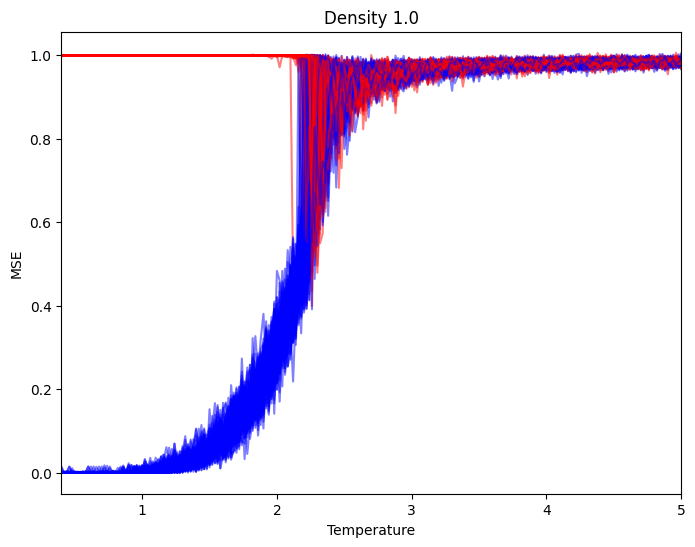

In [ ]:

mag1 = []
mag2 = []
for i in range(data.shape[0]):
	if clusters[i] == 0:
		mag1.append(data[i, :])
	else:
		mag2.append(data[i, :])
mag1 = np.array(mag1)
mag2 = np.array(mag2)


# Plot results
plt.figure(figsize=(8, 6))
for i in range(data.shape[0]):
	plt.plot(temperatures, data[i, :], color="red" if clusters[i] == 0 else "blue", alpha=0.5)

plt.xlabel("Temperature")
plt.ylabel("MSE")
plt.title(f"Density {density}")
plt.xlim(0.4, 5)
#plt.savefig(os.path.join('images', f'clusters_p{density}.pdf'))
plt.show()

In [ ]:
clusters.shape

(156,)

In [ ]:
predictions_cae.shape

(251, 156, 40, 40, 1)

In [ ]:
sim_images[0].shape

(251, 40, 40)

In [ ]:
mag_reconstrucciones.shape

(156, 251)

In [ ]:
mag_reconstrucciones[3, :20]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

# Gráficos

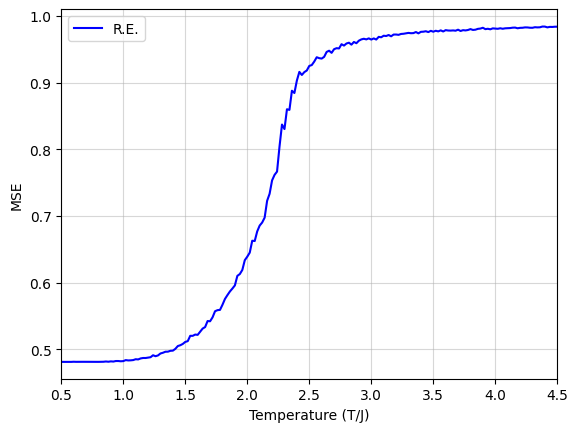

In [ ]:
data = pd.read_csv(os.path.join(folder, f"all_data_p1.0.csv"))
data = np.array(data)
predictions_cae = pred_cae[-1]

data_mean = np.mean(data, axis=0)

data_std = np.std(data, axis=0)

# Plot mean curve
plt.plot(temperatures, data_mean, color='blue', label='R.E.')

plt.xlabel("Temperature (T/J)")
plt.ylabel("MSE")
plt.xlim(0.5, 4.5)
plt.grid(alpha=0.5)
plt.legend()
plt.savefig(os.path.join(folder_figs, 'r_e_rho1.pdf'))
plt.show()

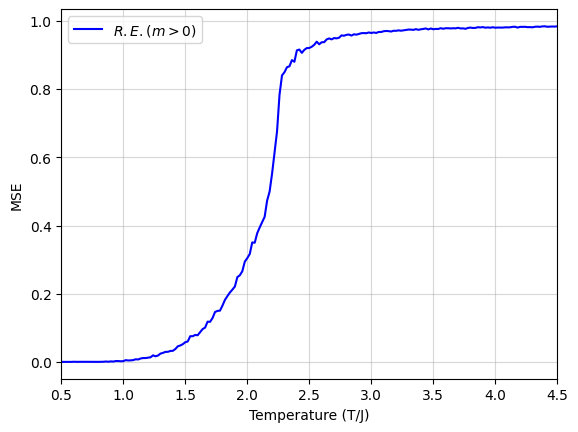

In [ ]:
data = pd.read_csv(os.path.join(folder, f"all_data_p1.0.csv"))
data = np.array(data)
low_temp_data = data[:, :20]  # Shape (20, 150)

# Apply k-means clustering (2 clusters)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(low_temp_data)  # Shape (150,)

mag1 = []
mag2 = []
for i in range(data.shape[0]):
	if clusters[i] == 0:
		mag1.append(data[i, :])
	else:
		mag2.append(data[i, :])
mag1 = np.array(mag1)
mag2 = np.array(mag2)

mag1_mean = np.mean(mag1, axis=0)
mag2_mean = np.mean(mag2, axis=0)

mag1_std = np.std(mag1, axis=0)
mag2_std = np.std(mag2, axis=0)

# Plot mean curve
#plt.plot(temperatures, mag1_mean, color='red', label=r'$m<0$')
plt.plot(temperatures, mag2_mean, color='blue', label=r'$R.E. (m>0)$')


#plt.plot(temperatures, std_curve, label='Standard Deviation', color='red')


plt.xlabel("Temperature (T/J)")
plt.ylabel("MSE")
plt.xlim(0.5, 4.5)
plt.legend()
plt.grid(alpha=0.5)
plt.savefig(os.path.join(folder_figs, 'r_e_m_positive.pdf'))
plt.show()

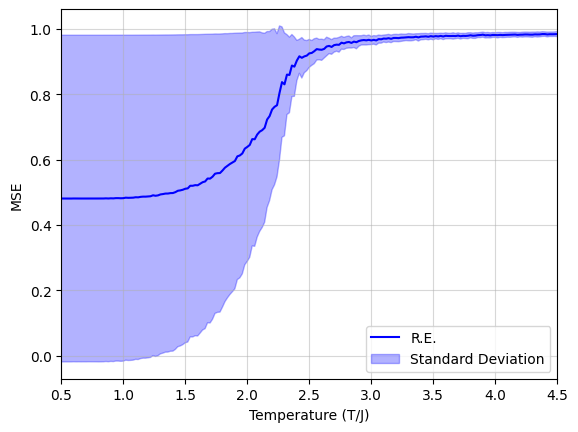

In [ ]:
data = pd.read_csv(os.path.join(folder, f"all_data_p1.0.csv"))
data = np.array(data)
predictions_cae = pred_cae[-1]

data_mean = np.mean(data, axis=0)

data_std = np.std(data, axis=0)

# Plot mean curve
plt.plot(temperatures, data_mean, color='blue', label='R.E.')

# Plot shaded error region (mean ± 1 std)
plt.fill_between(temperatures, data_mean - data_std, data_mean + data_std,
                color='blue', alpha=0.3, label='Standard Deviation')


plt.xlabel("Temperature (T/J)")
plt.ylabel("MSE")
plt.xlim(0.5, 4.5)
plt.grid(alpha=0.5)
plt.legend()
plt.savefig(os.path.join(folder_figs, 'reconstruction_error.pdf'))
plt.show()

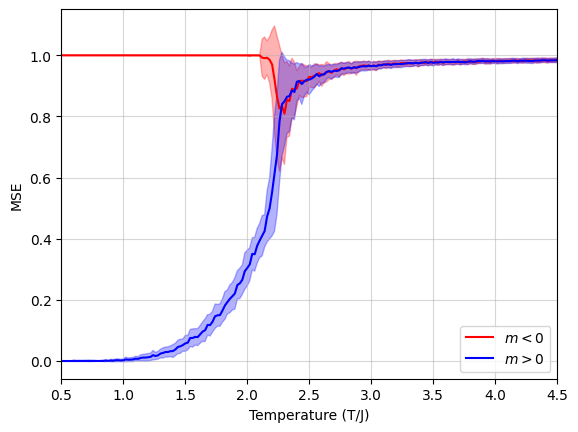

In [ ]:
data = pd.read_csv(os.path.join(folder, f"all_data_p1.0.csv"))
data = np.array(data)
low_temp_data = data[:, :20]  # Shape (20, 150)

# Apply k-means clustering (2 clusters)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(low_temp_data)  # Shape (150,)

mag1 = []
mag2 = []
for i in range(data.shape[0]):
  if clusters[i] == 0:
    mag1.append(data[i, :])
  else:
    mag2.append(data[i, :])
mag1 = np.array(mag1)
mag2 = np.array(mag2)

mag1_mean = np.mean(mag1, axis=0)
mag2_mean = np.mean(mag2, axis=0)

mag1_std = np.std(mag1, axis=0)
mag2_std = np.std(mag2, axis=0)

# Plot mean curve
plt.plot(temperatures, mag1_mean, color='red', label=r'$m<0$')
plt.plot(temperatures, mag2_mean, color='blue', label=r'$m>0$')

# Plot shaded error region (mean ± 1 std)
plt.fill_between(temperatures, mag1_mean - mag1_std, mag1_mean + mag1_std,
                color='red', alpha=0.3)
plt.fill_between(temperatures, mag2_mean - mag2_std, mag2_mean + mag2_std,
                color='blue', alpha=0.3)
#plt.plot(temperatures, std_curve, label='Standard Deviation', color='red')


plt.xlabel("Temperature (T/J)")
plt.ylabel("MSE")
plt.xlim(0.5, 4.5)
plt.legend()
plt.grid(alpha=0.5)
plt.savefig(os.path.join(folder_figs, 'reconstruction_error_states.pdf'))
plt.show()

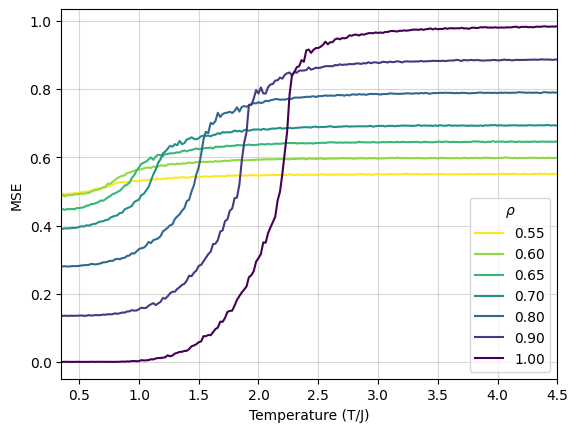

In [ ]:
densities = [0.55, 0.6, 0.65, 0.7, 0.8, 0.9, 1.0]
cmap = plt.cm.viridis_r
colors = cmap(np.linspace(0, 1, len(densities)))

plt.figure()
for i, density in enumerate(densities):
	data = pd.read_csv(os.path.join(folder, f"all_data_p{density}.csv"))
	data = np.array(data)

	low_temp_data = data[:, :20]  # Shape (20, 150)

	# Apply k-means clustering (2 clusters)
	kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
	clusters = kmeans.fit_predict(low_temp_data)  # Shape (150,)

	mag1 = []
	mag2 = []
	for j in range(data.shape[0]):
		if clusters[j] == 0:
			mag1.append(data[j, :])
		else:
			mag2.append(data[j, :])
	mag1 = np.array(mag1)
	mag2 = np.array(mag2)

	mag1_mean = np.mean(mag1, axis=0)
	mag2_mean = np.mean(mag2, axis=0)

	if np.min(mag1_mean) < np.min(mag2_mean):
		data_mean = mag1_mean
	else:
		data_mean = mag2_mean

	plt.plot(temperatures, data_mean, label=f'{density:0.2f}', color=colors[i])

	plt.xlabel("Temperature (T/J)")
	plt.ylabel("MSE")
	plt.xlim(0.35, 4.5)
	plt.grid(alpha=0.5)
	plt.legend(title=r'$\rho$')
	plt.savefig(os.path.join(folder_figs, 'all_errors.pdf'))
	plt.show()

In [ ]:
densities = [0.55, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.7, 0.8, 0.9, 1.0]

for density in densities:
	data = pd.read_csv(os.path.join(folder, f"all_data_p{density}.csv"))
	data = np.array(data)
	den = densities.index(density)
	predictions_cae = pred_cae[den]
	low_temp_data = data[:, :20]

	#mag_reconstrucciones = np.sum(predictions_cae, axis=(2, 3, 4)) / (40 * 40)
	#mag_reconstrucciones = mag_reconstrucciones.T

	sim_images, _ = loader_init.simulatedImages(den)

	mag_reconstrucciones = []
	for i in range(len(sim_images)):
		mag_reconstrucciones.append(np.sum(sim_images[i], axis=(1, 2)) / (40 * 40))
	mag_reconstrucciones = np.array(mag_reconstrucciones)

	magnetiz = []
	for i in range(mag_reconstrucciones.shape[0]):
		prom = np.mean(mag_reconstrucciones[i, 20:40])
		if prom > 0:
			magnetiz.append(1)
		else:
			magnetiz.append(-1)
	magnetiz = np.array(magnetiz)
	#low_temp_data = mag_reconstrucciones[:, :20]  # Shape (20, 150)

	# Apply k-means clustering (2 clusters)
	#kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
	#clusters = kmeans.fit_predict(low_temp_data)  # Shape (150,)

	# Plot results
	plt.figure(figsize=(8, 6))
	for i in range(data.shape[0]):  # Iterate over 150 curves
		plt.plot(temperatures, data[i, :], color="red" if magnetiz[i] > 0.0 else "blue", alpha=0.5)

	plt.xlabel("Temperature")
	plt.ylabel("MSE")
	plt.xlim(0.1, 3.5)
	plt.grid(alpha=0.5)
	#plt.title(f"Density {density}")
	plt.savefig(os.path.join(folder_figs, f'magnetizations_p{density}.pdf'))
	plt.show()

Output hidden; open in https://colab.research.google.com to view.

<ipython-input-79-0d456e5669df>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set2', len(densities))


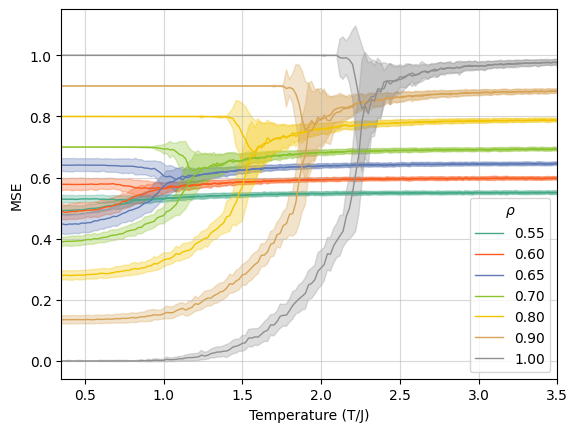

In [ ]:
densities = [0.55, 0.6, 0.65, 0.7, 0.8, 0.9, 1.0]

import colorsys

densities = [0.55, 0.6, 0.65, 0.7, 0.8, 0.9, 1.0]
cmap = plt.cm.get_cmap('Set2', len(densities))

# Get original colors and darken them
colors = cmap(np.arange(len(densities)))
darker_colors = []
for color in colors:
	# Convert RGB to HLS
	hls = colorsys.rgb_to_hls(color[0], color[1], color[2])

	# Reduce lightness (e.g., by 50%)
	darker_hls = (hls[0], hls[1] * 0.8, hls[2])  # Adjust the factor (0.5) to control darkness

	# Convert back to RGB
	darker_rgb = colorsys.hls_to_rgb(*darker_hls)
	darker_colors.append(darker_rgb)

#cmap = plt.cm.get_cmap('Set3', len(densities))
#colors = cmap(np.arange(len(densities)))
#colors = cmap(np.linspace(0, 1, len(densities)))

plt.figure()
for i, density in enumerate(densities):
	data = pd.read_csv(os.path.join(folder, f"all_data_p{density}.csv"))
	data = np.array(data)

	low_temp_data = data[:, :20]  # Shape (20, 150)

	# Apply k-means clustering (2 clusters)
	kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
	clusters = kmeans.fit_predict(low_temp_data)  # Shape (150,)

	mag1 = []
	mag2 = []
	for j in range(data.shape[0]):
		if clusters[j] == 0:
			mag1.append(data[j, :])
		else:
			mag2.append(data[j, :])
	mag1 = np.array(mag1)
	mag2 = np.array(mag2)

	mag1_mean = np.mean(mag1, axis=0)
	mag2_mean = np.mean(mag2, axis=0)

	mag1_std = np.std(mag1, axis=0)
	mag2_std = np.std(mag2, axis=0)


	# Plot shaded error region (mean ± 1 std)
	plt.fill_between(temperatures, mag1_mean - mag1_std, mag1_mean + mag1_std,
					color=darker_colors[i], alpha=0.3)
	plt.fill_between(temperatures, mag2_mean - mag2_std, mag2_mean + mag2_std,
					color=darker_colors[i], alpha=0.3)

	plt.plot(temperatures, mag1_mean, label=f'{density:0.2f}', color=darker_colors[i], linewidth=1)
	plt.plot(temperatures, mag2_mean, color=darker_colors[i], linewidth=1)

plt.xlabel("Temperature (T/J)")
plt.ylabel("MSE")
plt.xlim(0.35, 3.5)
plt.grid(alpha=0.5)
plt.legend(title=r'$\rho$')
plt.savefig(os.path.join(folder_figs, 'all_splits.pdf'))
plt.show()

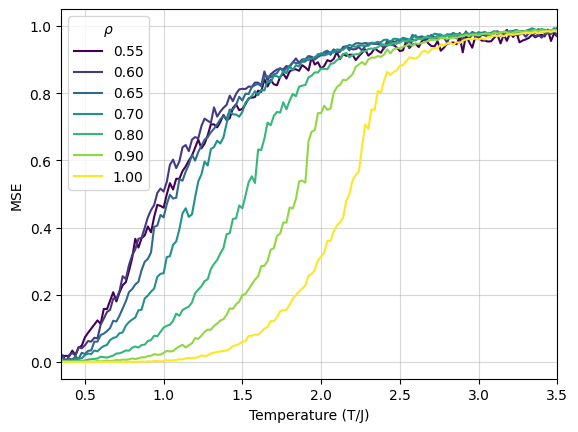

In [ ]:
densities = [0.55, 0.6, 0.65, 0.7, 0.8, 0.9, 1.0]
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(densities)))

plt.figure()
for i, density in enumerate(densities):
	data = pd.read_csv(os.path.join(folder, f"all_data_p{density}.csv"))
	data = np.array(data)
	low_temp_data = data[:, :20]  # Shape (20, 150)

	# Apply k-means clustering (2 clusters)
	kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
	clusters = kmeans.fit_predict(low_temp_data)  # Shape (150,)

	mag1 = []
	mag2 = []
	for j in range(data.shape[0]):
		if clusters[j] == 0:
			mag1.append(data[j, :])
		else:
			mag2.append(data[j, :])
	mag1 = np.array(mag1)
	mag2 = np.array(mag2)

	mag1_mean = np.mean(mag1, axis=0)
	mag2_mean = np.mean(mag2, axis=0)

	if np.min(mag1_mean) < np.min(mag2_mean):
		data_mean = mag1_mean
	else:
		data_mean = mag2_mean

	data_mean = np.mean(data, axis=0)

	normalized_data = (data_mean - np.min(data_mean)) / (np.max(data_mean) - np.min(data_mean))

	plt.plot(temperatures, normalized_data, label=f'{density:0.2f}', color=colors[i])

plt.xlabel("Temperature (T/J)")
plt.ylabel("MSE")
plt.xlim(0.35, 3.5)
plt.grid(alpha=0.5)
plt.legend(title=r'$\rho$')
plt.savefig(os.path.join(folder_figs, 'all_errors_normalized.pdf'))
plt.show()

<ipython-input-81-81b77fa9718e>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set2', len(densities))


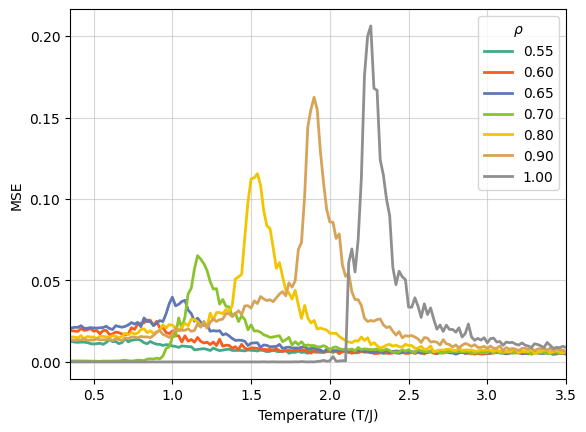

In [ ]:
densities = [0.55, 0.6, 0.65, 0.7, 0.8, 0.9, 1.0]

import colorsys

densities = [0.55, 0.6, 0.65, 0.7, 0.8, 0.9, 1.0]
cmap = plt.cm.get_cmap('Set2', len(densities))

# Get original colors and darken them
colors = cmap(np.arange(len(densities)))
darker_colors = []
for color in colors:
	# Convert RGB to HLS
	hls = colorsys.rgb_to_hls(color[0], color[1], color[2])

	# Reduce lightness (e.g., by 50%)
	darker_hls = (hls[0], hls[1] * 0.8, hls[2])  # Adjust the factor (0.5) to control darkness

	# Convert back to RGB
	darker_rgb = colorsys.hls_to_rgb(*darker_hls)
	darker_colors.append(darker_rgb)

#cmap = plt.cm.get_cmap('Set3', len(densities))
#colors = cmap(np.arange(len(densities)))
#colors = cmap(np.linspace(0, 1, len(densities)))

deviation = []
for i, density in enumerate(densities):
	data = pd.read_csv(os.path.join(folder, f"all_data_p{density}.csv"))
	data = np.array(data)

	low_temp_data = data[:, :20]  # Shape (20, 150)

	# Apply k-means clustering (2 clusters)
	kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
	clusters = kmeans.fit_predict(low_temp_data)  # Shape (150,)

	mag1 = []
	mag2 = []
	for j in range(data.shape[0]):
		if clusters[j] == 0:
			mag1.append(data[j, :])
		else:
			mag2.append(data[j, :])
	mag1 = np.array(mag1)
	mag2 = np.array(mag2)

	mag1_std = np.std(mag1, axis=0)
	deviation.append(mag1_std)

deviation = np.array(deviation)

plt.figure()
for i in range(deviation.shape[0]):
	density = densities[i]
	plt.plot(temperatures, deviation[i], label=f'{density:0.2f}', color=darker_colors[i], linewidth=2)

plt.xlabel("Temperature (T/J)")
plt.ylabel("MSE")
plt.xlim(0.35, 3.5)
plt.grid(alpha=0.5)
plt.legend(title=r'$\rho$')
plt.savefig(os.path.join(folder_figs, 'all_deviations.pdf'))
plt.show()

In [ ]:
densities = [0.55, 0.6, 0.65, 0.7, 0.8, 0.9, 1.0]
cmap = plt.cm.viridis_r
colors = cmap(np.linspace(0, 1, len(densities)))

plt.figure()
for i, density in enumerate(densities):
	data = pd.read_csv(os.path.join(folder, f"all_data_p{density}.csv"))
	data = np.array(data)

	low_temp_data = data[:, :20]  # Shape (20, 150)

	# Apply k-means clustering (2 clusters)
	kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
	clusters = kmeans.fit_predict(low_temp_data)  # Shape (150,)

	mag1 = []
	mag2 = []
	for j in range(data.shape[0]):
		if clusters[j] == 0:
			mag1.append(data[j, :])
		else:
			mag2.append(data[j, :])
	mag1 = np.array(mag1)
	mag2 = np.array(mag2)

	mag1_mean = np.mean(mag1, axis=0)
	mag2_mean = np.mean(mag2, axis=0)

	if np.min(mag1_mean) < np.min(mag2_mean):
		data_mean = mag1_mean
	else:
		data_mean = mag2_mean

	plt.plot(temperatures, data_mean, label=f'{density:0.2f}', color=colors[i])

plt.xlabel("Temperature (T/J)")
plt.ylabel("MSE")
plt.xlim(0.35, 4.5)
plt.grid(alpha=0.5)
plt.legend(title=r'$\rho$')
plt.savefig(os.path.join(folder_figs, 'all_errors_and_dev.pdf'))
plt.show()

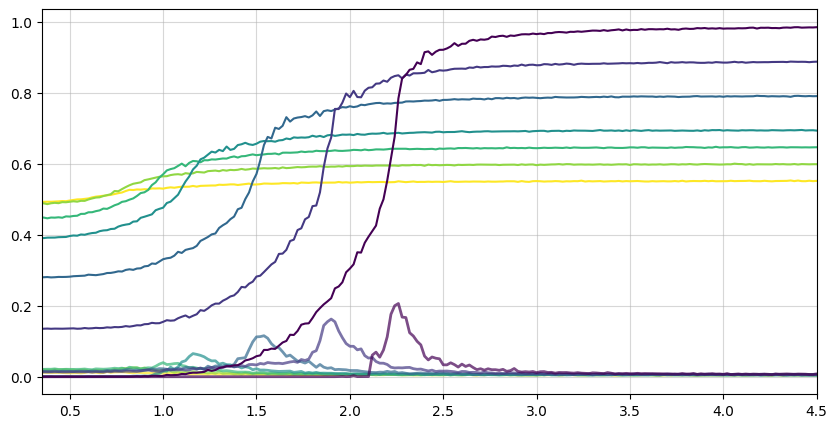

In [ ]:
densities = [0.55, 0.6, 0.65, 0.7, 0.8, 0.9, 1.0]
cmap = plt.cm.viridis_r
colors = cmap(np.linspace(0, 1, len(densities)))


deviation = []
magnetization = []
for i, density in enumerate(densities):
	data = pd.read_csv(os.path.join(folder, f"all_data_p{density}.csv"))
	data = np.array(data)

	low_temp_data = data[:, :20]  # Shape (20, 150)

	# Apply k-means clustering (2 clusters)
	kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
	clusters = kmeans.fit_predict(low_temp_data)  # Shape (150,)

	mag1 = []
	mag2 = []
	for j in range(data.shape[0]):
		if clusters[j] == 0:
			mag1.append(data[j, :])
		else:
			mag2.append(data[j, :])
	mag1 = np.array(mag1)
	mag2 = np.array(mag2)
	mag1_mean = np.mean(mag1, axis=0)
	mag2_mean = np.mean(mag2, axis=0)

	if np.min(mag1_mean) < np.min(mag2_mean):
		data_mean = mag1_mean
	else:
		data_mean = mag2_mean

	mag1_std = np.std(mag1, axis=0)
	deviation.append(mag1_std)
	magnetization.append(data_mean)

magnetization = np.array(magnetization)
deviation = np.array(deviation)

plt.figure(figsize=(10, 5))
for i in range(deviation.shape[0]):
	density = densities[i]
	plt.plot(temperatures, magnetization[i], label=f'{density:0.2f}', color=colors[i])
	plt.plot(temperatures, deviation[i], label=f'{density:0.2f}', color=colors[i], linewidth=2, alpha = 0.7)

plt.xlim(0.35, 4.5)
plt.grid(alpha=0.5)
plt.savefig(os.path.join(folder_figs, 'all_errors_and_dev.pdf'))
plt.show()

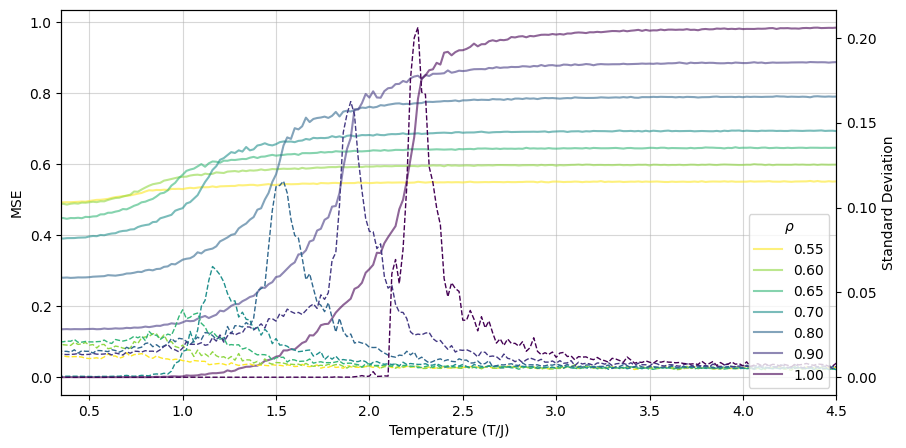

In [ ]:
densities = [0.55, 0.6, 0.65, 0.7, 0.8, 0.9, 1.0]
cmap = plt.cm.viridis_r
colors = cmap(np.linspace(0, 1, len(densities)))


deviation = []
magnetization = []
for i, density in enumerate(densities):
	data = pd.read_csv(os.path.join(folder, f"all_data_p{density}.csv"))
	data = np.array(data)

	low_temp_data = data[:, :20]  # Shape (20, 150)

	# Apply k-means clustering (2 clusters)
	kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
	clusters = kmeans.fit_predict(low_temp_data)  # Shape (150,)

	mag1 = []
	mag2 = []
	for j in range(data.shape[0]):
		if clusters[j] == 0:
			mag1.append(data[j, :])
		else:
			mag2.append(data[j, :])
	mag1 = np.array(mag1)
	mag2 = np.array(mag2)
	mag1_mean = np.mean(mag1, axis=0)
	mag2_mean = np.mean(mag2, axis=0)

	if np.min(mag1_mean) < np.min(mag2_mean):
		data_mean = mag1_mean
	else:
		data_mean = mag2_mean

	mag1_std = np.std(mag1, axis=0)
	deviation.append(mag1_std)
	magnetization.append(data_mean)

magnetization = np.array(magnetization)
deviation = np.array(deviation)

fig, ax1 = plt.subplots(figsize=(10,5))  # Create the first y-axis

# Plot magnetization on the first y-axis (left)
for i in range(deviation.shape[0]):
    density = densities[i]
    ax1.plot(temperatures, magnetization[i], label=f'{density:0.2f}', color=colors[i], linewidth=1.5, alpha=0.6)

ax1.set_xlabel("Temperature (T/J)")
ax1.set_ylabel("MSE", color='black')  # Label for the first y-axis
ax1.tick_params(axis='y', labelcolor='black')  # Set tick color for the first y-axis
ax1.set_xlim(0.35, 4.5)
ax1.grid(alpha=0.5)

# Create the second y-axis (right)
ax2 = ax1.twinx()

# Plot deviation on the second y-axis (right)
for i in range(deviation.shape[0]):
    density = densities[i]
    ax2.plot(temperatures, deviation[i], color=colors[i], linewidth=1, linestyle='--')  # Use dashed line for deviation

ax2.set_ylabel("Standard Deviation", color='black')  # Label for the second y-axis
ax2.tick_params(axis='y', labelcolor='black')  # Set tick color for the second y-axis

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, title=r'$\rho$', loc='lower right')  # Adjust legend location as needed

plt.savefig(os.path.join(folder_figs, 'all_errors_and_dev.pdf'))  # Save with a different filename
plt.show()

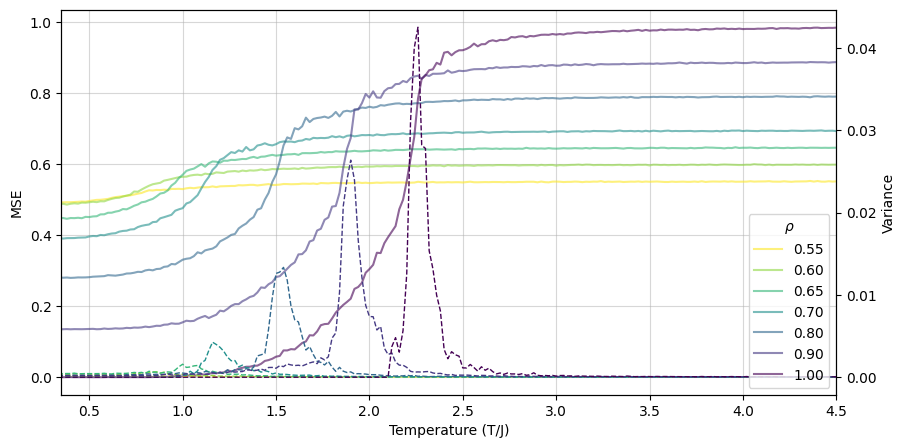

In [ ]:
densities = [0.55, 0.6, 0.65, 0.7, 0.8, 0.9, 1.0]
cmap = plt.cm.viridis_r
colors = cmap(np.linspace(0, 1, len(densities)))


varianza = []
magnetization = []
for i, density in enumerate(densities):
	data = pd.read_csv(os.path.join(folder, f"all_data_p{density}.csv"))
	data = np.array(data)

	low_temp_data = data[:, :20]  # Shape (20, 150)

	# Apply k-means clustering (2 clusters)
	kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
	clusters = kmeans.fit_predict(low_temp_data)  # Shape (150,)

	mag1 = []
	mag2 = []
	for j in range(data.shape[0]):
		if clusters[j] == 0:
			mag1.append(data[j, :])
		else:
			mag2.append(data[j, :])
	mag1 = np.array(mag1)
	mag2 = np.array(mag2)
	mag1_mean = np.mean(mag1, axis=0)
	mag2_mean = np.mean(mag2, axis=0)

	if np.min(mag1_mean) < np.min(mag2_mean):
		data_mean = mag1_mean
	else:
		data_mean = mag2_mean

	mag1_var = np.var(mag1, axis=0)
	varianza.append(mag1_var)
	magnetization.append(data_mean)

magnetization = np.array(magnetization)
varianza = np.array(varianza)

fig, ax1 = plt.subplots(figsize=(10,5))  # Create the first y-axis

# Plot magnetization on the first y-axis (left)
for i in range(deviation.shape[0]):
    density = densities[i]
    ax1.plot(temperatures, magnetization[i], label=f'{density:0.2f}', color=colors[i], linewidth=1.5, alpha=0.6)

ax1.set_xlabel("Temperature (T/J)")
ax1.set_ylabel("MSE", color='black')  # Label for the first y-axis
ax1.tick_params(axis='y', labelcolor='black')  # Set tick color for the first y-axis
ax1.set_xlim(0.35, 4.5)
ax1.grid(alpha=0.5)

# Create the second y-axis (right)
ax2 = ax1.twinx()

# Plot deviation on the second y-axis (right)
for i in range(varianza.shape[0]):
    density = densities[i]
    ax2.plot(temperatures, varianza[i], color=colors[i], linewidth=1, linestyle='--')  # Use dashed line for deviation

ax2.set_ylabel("Variance", color='black')  # Label for the second y-axis
ax2.tick_params(axis='y', labelcolor='black')  # Set tick color for the second y-axis

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, title=r'$\rho$', loc='lower right')  # Adjust legend location as needed

plt.savefig(os.path.join(folder_figs, 'all_errors_and_var.pdf'))  # Save with a different filename
plt.show()